<a href="https://colab.research.google.com/github/otausendschoen/NLP_Yahoo-Answers/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

# *Yahoo Answers Topic Classification*

### Authors: **Tirdod, Behbehani, Marvin Ernst, Pol Garcia, Oliver Tausendschön** 

#### Class: **22DM015 Advanced Methods in Natural Language Processing**

##### *Final Assigment*

##### Supervisor: **Arnault Gombert**

**Date: June 15, 2025**

We follow the structure defined in the assignment instructions. Please see the clickable [Table of Contents](#table-of-contents) below.

## Table of Contents

0. **[Dataset Selection](#part-0-dataset-selection)**  
1. **[Problem Setup](#part-1-problem-setup)**  
   a. [Bibliography and State of the Art](#a-bibliography-and-soa)  
   b. [Dataset Description](#b-dataset-description)  
   c. [Random Classifier](#c-random-classifier-performance)  
   d. [Rule-based Baseline](#d-baseline-implementation)  
2. **[Data Scientist Challenge](#part-2-data-scientist-challenge)**  
   a. [BERT with 32 Labels](#a-bert-model-with-limited-data)  
   b. [Dataset Augmentation (non-LLM)](#b-dataset-augmentation)  
   c. [Zero-Shot Learning with LLM](#c-zero-shot-learning-with-llm)  
   d. [Data Generation with LLM](#d-data-generation-with-llm)  
   e. [Optimal Technique Selection](#e-optimal-technique-application)  

**Colab and Imports Setup**

**Only install if running in Colab:**

In [10]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !pip install -q datasets transformers evaluate fsspec
    !pip install -q nltk wordcloud lime langdetect matplotlib
    !pip uninstall -y scikit-learn
    !pip install -q scikit-learn==1.6.1

**Hugging Face Login (run everywhere):**

In [1]:
from huggingface_hub import notebook_login, login, HfApi, HfFolder

# For Colab or fresh sessions
notebook_login()  # interactive popup
login()  # prompts for HF token

**Core Imports (run everywhere):**

In [2]:
import os, random, re, string, torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter, defaultdict
from datasets import load_dataset, Dataset, DatasetDict
from nltk.corpus import stopwords
from wordcloud import WordCloud
from langdetect import detect
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE

from lime.lime_text import LimeTextExplainer
from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
import evaluate

Random seed for reproducibility:

In [3]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# Part 0: Dataset Selection

We use the **Yahoo Answers Topics** dataset via Hugging Face (`community-datasets/yahoo_answers_topics`). It contains over 1.4 million question-answer samples across **10 balanced topic classes**.

Each row includes:
- `question_title`
- `question_content`
- `best_answer`
- `topic` (integer ID 0–9 with mapped names)

This dataset contains a large number of questions and their respective answers in topics such as sports, business & finance, society & culture, science & mathematics, family & relationships, computers & the internet, and more.


Load the dataset:

In [4]:
train_dataset = load_dataset("community-datasets/yahoo_answers_topics", split="train")
test_dataset = load_dataset("community-datasets/yahoo_answers_topics", split="test")

README.md:   0%|          | 0.00/5.20k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/241M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/270M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/21.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1400000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Convert to pandas DataFrame for easier handling:

In [5]:
df = pd.concat([train_dataset.to_pandas(), test_dataset.to_pandas()]).reset_index(drop=True)
label_map = {'Society & Culture': 0, 'Science & Mathematics': 1, 'Health': 2, 'Education & Reference': 3,
             'Computers & Internet': 4, 'Sports': 5, 'Business & Finance': 6, 'Entertainment & Music': 7,
             'Family & Relationships': 8, 'Politics & Government': 9}

Basic info:

In [6]:
print(f"Dataset size: {len(df)} documents")
df.head()

Dataset size: 1460000 documents


id  topic                                     question_title  \
0   0      4  why doesn't an optical mouse work on a glass t...   
1   1      5       What is the best off-road motorcycle trail ?   
2   2      2             What is Trans Fat? How to reduce that?   
3   3      6                         How many planes Fedex has?   
4   4      6  In the san francisco bay area, does it make se...   

                                    question_content  \
0                          or even on some surfaces?   
1                  long-distance trail throughout CA   
2  I heard that tras fat is bad for the body.  Wh...   
3  I heard that it is the largest airline in the ...   
4  the prices of rent and the price of buying doe...   

                                         best_answer  
0  Optical mice use an LED and a camera to rapidl...  
1  i hear that the mojave road is amazing!<br />\...  
2  Trans fats occur in manufactured foods during ...  
3  according to the www.fedex.com web site:\nAir ...  
4  renting vs buying depends on your goals. <br /...

# Part 1: Problem Setup

**Objective**:

The goal of this project is to build and evaluate models for automated topic classification on the Yahoo Answers dataset. This dataset contains user-submitted questions categorized into broad topics. By establishing a baseline performance through random and rule-based classifiers, and reviewing the state of the art, we aim to understand the challenges of this task and prepare for building more sophisticated models in later stages.


## a) Bibliography and SOA


**Main Objective**: 

The task is a multi-class text classification. We will be classifying topics as it is often conceived a natural first supervised learning task due to its clear label structure and real-world applicability. Additionally, there are multiple research papers available acting as a baseline.


**Business Case**:  

In practice, it's common for businesses to receive a large number of customer questions through support channels. These questions can cover a wide variety of topics - from product functionality and billing issues to technical problems and general inquiries. This diversity makes customer service more complex, as each question typically needs to be routed to the appropriate department manually.

A department handling all topics at once would be inefficient because it would slow down response times, overload general support staff, and increase the chance of miscommunication or misrouting. Without this topic-awareness, questions may bounce between departments, leading to customer frustration and operational delays.

By implementing a topic classification system, businesses can automatically categorize incoming queries and send them directly to the relevant team. This allows specialized agents to address issues more quickly and effectively, improving both customer satisfaction and internal workflow efficiency. Only after a question is correctly identified in terms of its topic can it be answered in a relevant and high-quality manner.

**State of the Art**:

Due to the datasets popularity, there have been a lot of attempts in utilizing this text data for classification purposes. This includes different methodologies, from rule-based classification, SVM, Neural Networks and Large Language models. Below are some papers that explore it in different ways, showcasing how different methodologies yield slightly different results and how it got better over time with more suffisticated models:

- Zhang et al. (2015) introduced the Yahoo Answers dataset as part of a suite of large-scale text classification benchmarks. They compared traditional models like n-gram TF-IDF + Logistic Regression against deep neural networks, including character-level CNNs. This work already highlighted the limitations of shallow models and the potential of deep architectures in capturing richer language patterns.
https://arxiv.org/abs/1509.01626


- Kumar et al. (2017) applied hierarchical SVM-based classifiers to Yahoo Answers questions, modeling the structure of categories to improve accuracy over flat classification.
https://www.researchgate.net/publication/224345610_Applying_Question_Classification_to_Yahoo_Answers


- Overall, recent benchmarks on PapersWithCode show that modern models like transformer (BERT, RoBERTa, and DistilBERT) significantly outperform earlier approaches. Fine-tuned RoBERTa-base models can achieve nearly 80% accuracy, compared to ~70% for traditional methods.
https://paperswithcode.com/sota/text-classification-on-yahoo-answers


| Rank | Model             | Accuracy (%) | Paper Title                                                                 | Year |
|------|-------------------|--------------|------------------------------------------------------------------------------|------|
| 1    | BERT-ITPT-FiT     | 77.62        | How to Fine-Tune BERT for Text Classification?                              | 2019 |
| 2    | DRNN              | 76.26        | Disconnected Recurrent Neural Networks for Text Categorization              | 2018 |
| 3    | DELTA (HAN)       | 75.10        | DELTA: A DEep learning based Language Technology plAtform                   | 2019 |
| 4    | EXAM              | 74.80        | Explicit Interaction Model towards Text Classification                      | 2018 |
| 5    | DNC+CUW           | 74.30        | Learning to Remember More with Less Memorization                            | 2019 |
| 6    | ULMFiT (Small data)| 74.30       | Sampling Bias in Deep Active Classification: An Empirical Study             | 2019 |
| 7    | CCCapsNet         | 73.85        | Compositional Coding Capsule Network with K-Means Routing for Text Classification | 2018 |
| 8    | SWEM-concat       | 73.53        | Baseline Needs More Love: On Simple Word-Embedding-Based Models and Associated Pooling Mechanisms | 2018 |
| 9    | FastText          | 72.30        | Bag of Tricks for Efficient Text Classification                             | 2016 |
| 10   | Seq2CNN (50)      | 55.39        | Abstractive Text Classification Using Sequence-to-convolution Neural Networks | 2018 |


![image.png](attachment:image.png)

**Figure 1:** Accuracy of top models on the Yahoo Answers text classification task. Source: [Papers With Code – Yahoo Answers](https://paperswithcode.com/sota/text-classification-on-yahoo-answers)

## b) Dataset Description


The dataset used is **Yahoo Answers Topics**, a large dataset (1.4M rows) containing community question and answer pairs across 10 topic categories. Each sample includes a question title, question content, best answer, and a numeric label for the topic.

Below is a summary including dataset size, class distribution, and average lengths of the question and answer texts.

Total samples: 1460000
Number of classes: 10
Average question length (words): 21.66
Average answer length (words): 59.18
Average question length (characters): 116.57
Average answer length (characters): 345.07
Minimum question length (words): 0
Minimum answer length (words): 0
Maximum question length (words): 910
Maximum answer length (words): 1169
Missing questions: 0
Missing answers: 0

Class distribution:
Society & Culture: 146000
Science & Mathematics: 146000
Health: 146000
Education & Reference: 146000
Computers & Internet: 146000
Sports: 146000
Business & Finance: 146000
Entertainment & Music: 146000
Family & Relationships: 146000
Politics & Government: 146000


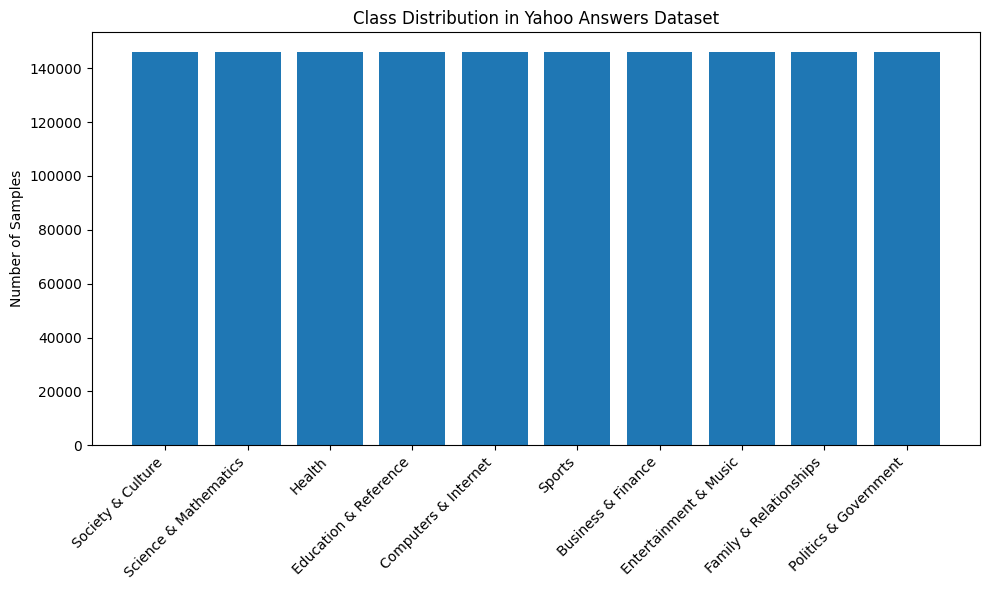

In [7]:
# Descriptive statistics
dataset_size = len(df)
class_names = train_dataset.features['topic'].names
class_distribution = df['topic'].value_counts().sort_index()
class_counts_named = {class_names[i]: class_distribution[i] for i in range(len(class_names))}

avg_question_length = df['question_content'].apply(lambda x: len(x.split())).mean()
avg_answer_length = df['best_answer'].apply(lambda x: len(x.split())).mean()
avg_question_length_char = df['question_content'].apply(lambda x: len(x)).mean()
avg_answer_length_char = df['best_answer'].apply(lambda x: len(x)).mean()
min_question_length = df['question_content'].apply(lambda x: len(x.split())).min()
min_answer_length = df['best_answer'].apply(lambda x: len(x.split())).min()
max_question_length = df['question_content'].apply(lambda x: len(x.split())).max()
max_answer_length = df['best_answer'].apply(lambda x: len(x.split())).max()
missing_questions = df['question_content'].isnull().sum()
missing_answers = df['best_answer'].isnull().sum()

# Print summary
print("Total samples:", dataset_size)
print("Number of classes:", len(class_names))
print("Average question length (words):", round(avg_question_length, 2))
print("Average answer length (words):", round(avg_answer_length, 2))
print("Average question length (characters):", round(avg_question_length_char, 2))
print("Average answer length (characters):", round(avg_answer_length_char, 2))
print("Minimum question length (words):", min_question_length)
print("Minimum answer length (words):", min_answer_length)
print("Maximum question length (words):", max_question_length)
print("Maximum answer length (words):", max_answer_length)
print("Missing questions:", missing_questions)
print("Missing answers:", missing_answers)
print("\nClass distribution:")
for cls, count in class_counts_named.items():
    print(f"{cls}: {count}")

# Plot class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_distribution)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Yahoo Answers Dataset")
plt.tight_layout()
plt.show()

Overall, we have 1 460 000 samples in this dataset. Furhtermore, it is evenly distributed across all 10 classes, with **146,000 samples per class**, making it **balanced** — a desirable property for training classification models without introducing bias toward more frequent classes.

In terms of text statistics:
- The **average question content length** is approximately **22 words**.
- The **average best answer length** is around **59 words**.
- Minimum and maximum word counts range from very short single-sentence questions to long multi-sentence answers (optional to mention if you've calculated them).

This difference in length suggests that answers tend to be significantly more verbose than the questions, which is expected in a Q&A format. The balanced class distribution and large sample size make this dataset well-suited for benchmarking text classification models.

No missing values or duplicates were observed in the provided training split. However, there appears to be some kind of empty string answers and questions, as the minimum answer and question length is 0. Therefore, we filter these out of the dataframe below

In [8]:
empty_questions = df['question_content'].apply(lambda x: x.strip() == "")
empty_answers = df['best_answer'].apply(lambda x: x.strip() == "")

print("Empty questions:", empty_questions.sum())
print("Empty answers:", empty_answers.sum())

df = df[~empty_questions & ~empty_answers]

Empty questions: 658761
Empty answers: 25606


---
**Run everything above this cell to get the cleaned dataframe ready to work with.**

Minimum question length (words): 1
Minimum answer length (words): 1
Questions with 3 or fewer words: 37678
Answers with 3 or fewer words: 45856


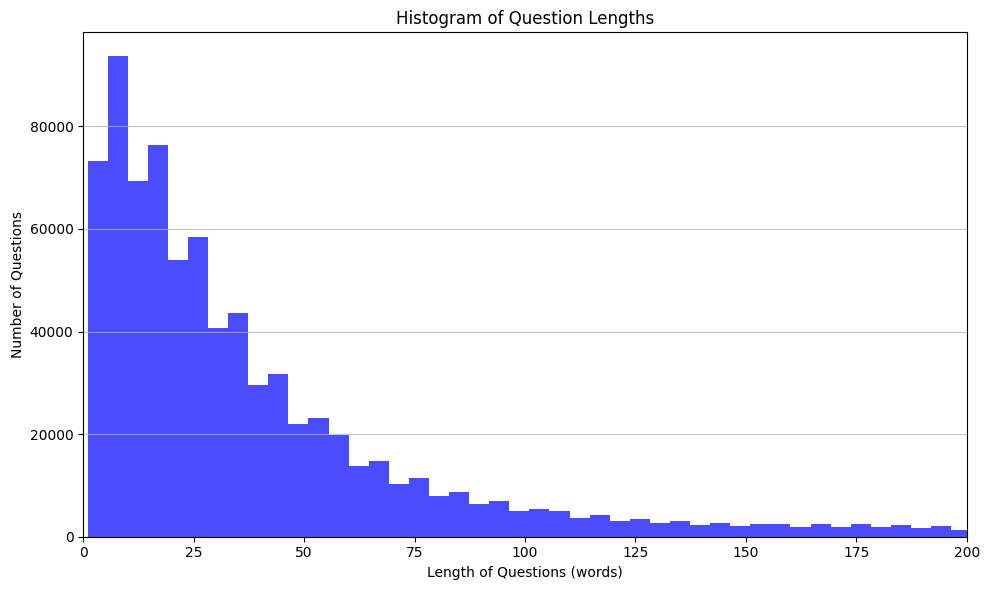

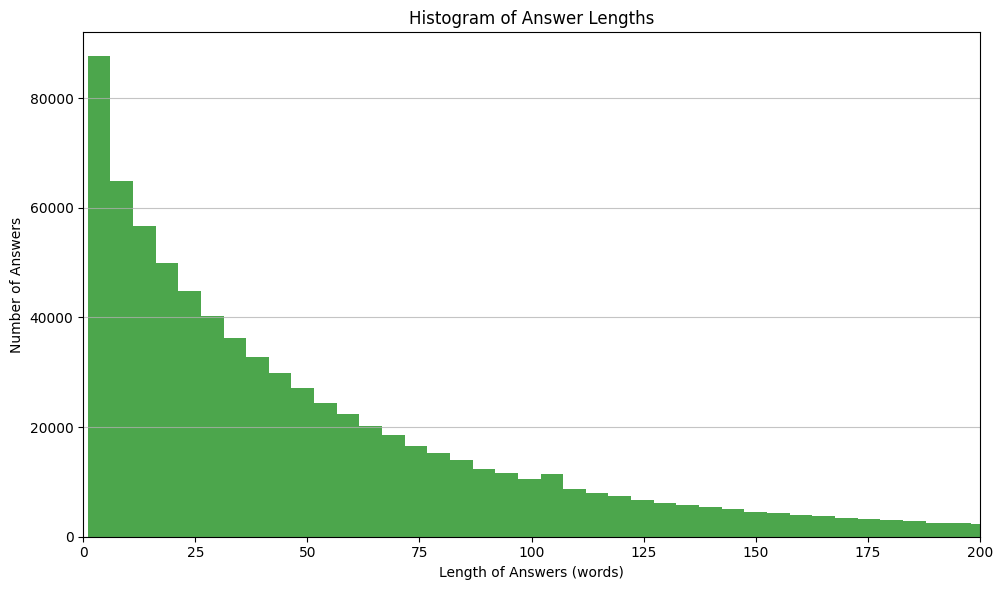

In [9]:
# Check for empty questions and answers again
min_question_length = df['question_content'].apply(lambda x: len(x.split())).min()
min_answer_length = df['best_answer'].apply(lambda x: len(x.split())).min()

print("Minimum question length (words):", min_question_length)
print("Minimum answer length (words):", min_answer_length)

short_questions = df['question_content'].apply(lambda x: len(x.split()) <= 3).sum()
print(f"Questions with 3 or fewer words: {short_questions}")

# Count answers with 3 or fewer words
short_answers = df['best_answer'].apply(lambda x: len(x.split()) <= 3).sum()
print(f"Answers with 3 or fewer words: {short_answers}")


#plot a histogram of the length of the questions
plt.figure(figsize=(10, 6))
plt.hist(df['question_content'].apply(lambda x: len(x.split())), bins=200, alpha=0.7, color='blue')
plt.xlabel("Length of Questions (words)")
plt.ylabel("Number of Questions")
plt.title("Histogram of Question Lengths")
plt.grid(axis='y', alpha=0.75)
plt.xlim(0, 200)
plt.tight_layout()
plt.show()
#plot a histogram of the length of the answers
plt.figure(figsize=(10, 6))
plt.hist(df['best_answer'].apply(lambda x: len(x.split())), bins=200, alpha=0.7, color='green')
plt.xlabel("Length of Answers (words)")
plt.ylabel("Number of Answers")
plt.title("Histogram of Answer Lengths")
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.xlim(0, 200)
plt.show()

We can see that we have quite a few cases where questions or answers are extremely short - specifically, 37,678 questions and 45,856 answers contain three words or fewer. After filtering out completely empty entries, the minimum question and answer lengths increased to 1 word. However, some of these very short entries likely still contain low-information or meaningless text (e.g., "help", "why?", "okay").

Despite this, we choose not to remove these cases, for a few reasons:

- First, their presence reflects the natural noise of user-generated content, which models in production settings are likely to encounter.

- Second, the dataset remains large and balanced, so these outliers are unlikely to skew the overall learning process.

- Finally, short or vague questions may still contain subtle topic cues (e.g., a question like "Windows issue" may still be clearly technical).

For these reasons, we retain the short samples and proceed with the cleaned dataset, accepting a small degree of noise as part of the task's inherent complexity.

Finally, we will check which languages we are dealing with! It can be helpful when it comes to preprocessing techniques or stopword removals!

For analytical purposes to check the language distribution, we will use a subset of only 100 000 samples to avoid high computational times. We will also use this subset for the wordcloud below!

In [10]:
# Function detect language
def safe_detect(text):
    try:
        return detect(text) if isinstance(text, str) and text.strip() else "unknown"
    except:
        return "error"
#create new column
sample_df = df.sample(100000, random_state=42)
sample_df["lang"] = sample_df["question_content"].apply(safe_detect)
language_counts = print(sample_df["lang"].value_counts())


print(language_counts)

lang
en       94952
fr         623
af         528
error      418
nl         352
it         274
de         266
cy         264
no         250
so         220
tl         196
ca         188
da         169
ro         147
pt         146
es         126
id         122
et         111
vi          94
pl          77
sw          63
sv          62
hr          57
sq          48
fi          45
tr          42
sl          37
hu          35
sk          30
cs          20
lt          17
lv          12
ar           4
ru           2
he           1
el           1
zh-cn        1
Name: count, dtype: int64
None


We can see that our corpus is predominantly in English, which means our classifier will likely also learn English language patterns.
We acknowledge that there is the possibility to filter to only English content to reduce the noise. Nevertheless, we will carry on including everything for now and potentially adress if deemed necessary.

## c) Random Classifier Performance

A random classifier assigns a class label to each sample by randomly selecting from the available topic classes.
Random means we basically toss a coin, so if we have 1 class and 1 sample it will be correct 50% of the tosses. This can also be calculated for many samples. As long as the balance of the classes remain the same. If we had 1 sample and for classes it would be 25%.

Since the Yahoo Answers dataset is balanced across these 10 classes, the expected performance of such a classifier is:

$
\frac{1}{10} = 0.10 \text{, so } 10\%
$

We will confirm this through a simple simulation below.

In [39]:
# Simulate random predictions
num_samples = len(df)
num_classes = 10
random_preds = np.random.randint(0, num_classes, size=num_samples)

# True labels
true_labels = df['topic']

# Accuracy of random predictions
random_accuracy = accuracy_score(true_labels, random_preds)
print(f"Simulated Random Classifier Accuracy: {random_accuracy:.4f}")

Simulated Random Classifier Accuracy: 0.0999


We can confirm that our calculation is correct!

## d) Baseline Implementation

To develop a rule-based baseline classifier, we first generated word clouds for each topic class using the subset of the training data. By visually inspecting the most prominent words, we manually selected a list of distinctive keywords for each class that capture its semantic domain. Importantly, there are some words that should be ignored or added to the stopwords as they appear in multiple topics (i.e. "now" appears in all wordclouds).

Additionally, we include some intuition baswed words (e.g., "doctor", "medicine" for Health, or "movie", "band" for Entertainment & Music) which should clearly define the corresponding topics.

We then implemented a simple keyword-matching function that assigns a class label if any of the keywords appear in the input question. After that, we analyze with lime if our intuition is right and improve if it's necessary.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


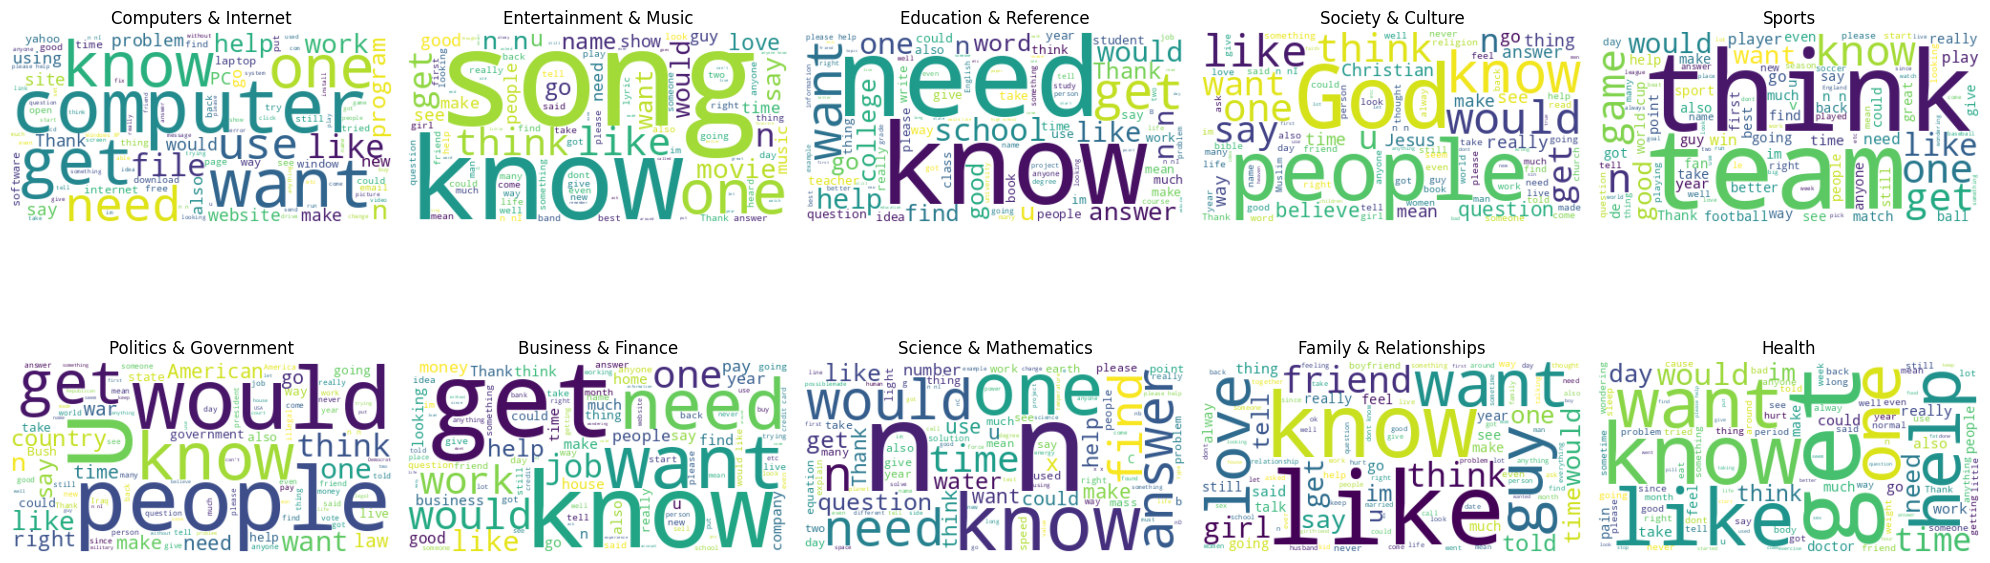

In [ ]:
# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
# Get label names from above
label_names = class_names

# Aggregate question content by topic
label_text = defaultdict(str)
for text, label in zip(sample_df['question_content'], sample_df['topic']):
    label_text[label] += ' ' + text

# Generate and plot word clouds
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
axs = axs.flatten()

for idx, (label, text) in enumerate(label_text.items()):
    wordcloud = WordCloud(
        stopwords=stop_words,
        background_color='white',
        max_words=100
    ).generate(text)

    axs[idx].imshow(wordcloud, interpolation='bilinear')
    axs[idx].set_title(f"{label_names[label]}", fontsize=12)
    axs[idx].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Define keywords for each class
rules = {
    "Health": ["day", "time", "doctor", "medicine", "pain", "symptom"],
    "Computers & Internet": ["using", "problem", "windows", "wifi", "laptop", "computer", "browser"],
    "Politics & Government": ["law", "say", "country", "election", "government", "president", "senate"],
    "Sports": ["think", "game", "score", "team", "football", "league"],
    "Science & Mathematics": ["one", "question", "math", "science", "chemistry", "physics", "equation"],
    "Education & Reference": ["school", "college", "university", "study", "homework"],
    "Business & Finance": ["work","money", "business", "finance", "investment", "stock"],
    "Entertainment & Music": ["movie", "music", "concert", "band", "album"],
    "Family & Relationships": ["guy", "answer", "marriage", "relationship", "family", "friend", "love"],
    "Society & Culture": ["people", "god", "culture", "world", "travel"],
}

name_to_id = {name: idx for idx, name in enumerate(label_names)}

print(name_to_id)
# Simple classifier
def classify_rule_based(text):
    text = text.lower()
    for label, keywords in rules.items():
        if any(word in text for word in keywords):
            return name_to_id[label]
    # If no keywords match, return a fallback class, randomly assigning a class 0-9
    random_class = np.random.choice(list(rules.keys()))
    return name_to_id[random_class]
# Apply the rule-based classifier
df['predicted_label'] = df['question_content'].apply(classify_rule_based)
# Calculate accuracy
accuracy = accuracy_score(df['topic'], df['predicted_label'])
print(f"Rule-based Classifier Accuracy: {accuracy:.4f}")

{'Society & Culture': 0, 'Science & Mathematics': 1, 'Health': 2, 'Education & Reference': 3, 'Computers & Internet': 4, 'Sports': 5, 'Business & Finance': 6, 'Entertainment & Music': 7, 'Family & Relationships': 8, 'Politics & Government': 9}
Rule-based Classifier Accuracy: 0.2000


Accuracy is about **20%**, which is quite a bit better than the odds! Let's check the most common words in false predictions to improve this a bit.

### Improvement and Final Accuracy

In [ ]:
# Choose a class to analyze
target_class_id = name_to_id["Health"]
target_class_name = label_names[target_class_id]

# Split into true positives and false positives
true_positives = df[(df['predicted_label'] == target_class_id) & (df['topic'] == target_class_id)]
false_positives = df[(df['predicted_label'] == target_class_id) & (df['topic'] != target_class_id)]

def get_word_counts(series):
    counter = Counter()
    for text in series.dropna():
        tokens = re.findall(r'\b\w+\b', text.lower())
        counter.update(tokens)
    return counter

# Get word frequencies
tp_counts = get_word_counts(true_positives['question_content'])
fp_counts = get_word_counts(false_positives['question_content'])

# Words unique to true or false positives
unique_tp_words = {w: f for w, f in tp_counts.items() if w not in fp_counts}
unique_fp_words = {w: f for w, f in fp_counts.items() if w not in tp_counts}

# Top 20 for each
print(f"\nMost distinctive words in TRUE POSITIVES for '{target_class_name}':")
print(sorted(unique_tp_words.items(), key=lambda x: x[1], reverse=True)[:20])

print(f"\nMost distinctive words in FALSE POSITIVES predicted as '{target_class_name}':")
print(sorted(unique_fp_words.items(), key=lambda x: x[1], reverse=True)[:20])


Most distinctive words in TRUE POSITIVES for 'Health':
[('heartburn', 61), ('wellbutrin', 57), ('ortho', 56), ('bloating', 53), ('lightheaded', 41), ('yasmin', 38), ('gerd', 33), ('dandruff', 33), ('sunscreen', 32), ('klonopin', 31), ('l5', 30), ('vertigo', 29), ('lotions', 28), ('gout', 27), ('ointment', 27), ('scoliosis', 26), ('lumbar', 26), ('lyme', 26), ('achy', 25), ('tonsilitis', 25)]

Most distinctive words in FALSE POSITIVES predicted as 'Health':
[('islam', 730), ('immigrants', 658), ('password', 489), ('democrats', 461), ('evolution', 437), ('israel', 418), ('jews', 415), ('federal', 406), ('congress', 401), ('worship', 395), ('liberal', 374), ('illegals', 361), ('explorer', 355), ('leader', 355), ('wwe', 353), ('ram', 351), ('printer', 345), ('weapons', 325), ('spyware', 316), ('nations', 313)]


With this, we can see which words are the most important for true positives and false positives and adapt our rule based classifier to include these terms correctly.



In [ ]:
rules["Politics & Government"].extend([
    "immigrants", "democrats", "congress", "liberal", "federal",
    "illegals", "leader", "weapons", "troops"
])

rules["Society & Culture"].extend([
    "islam", "jews", "worship", "israel", "nations", "evolution"
])

rules["Computers & Internet"].extend([
    "password", "explorer", "printer", "ram"
])

rules["Entertainment & Music"].append("wwe")

rules["Health"].extend([
    "doctor", "medicine", "pain", "symptom", "health", "hospital", "treatment",
    "illness", "disease", "calorie", "heartburn", "ortho", "bloating",
    "lightheaded", "yasmin", "gerd", "dandruff", "klonopin", "ointment",
    "sunscreen", "l5", "lyme", "gout", "scoliosis", "lumbar", "achy",
    "tonsilitis", "cyclen", "monistat"
])

df['predicted_label'] = df['question_content'].apply(classify_rule_based)
# Calculate accuracy
accuracy = accuracy_score(df['topic'], df['predicted_label'])
print(f"Rule-based Classifier Accuracy: {accuracy:.4f}")


Rule-based Classifier Accuracy: 0.2125


We can see how we improved the accuracy by about 1.5%, which is a slight improvement but considering we only did the improvement by analysing the FP and TP for the `Health` class it's quite decent.
We will not be applying this method to all topics to keep this report short and precise but we admit that there is more potential by doing something like it in this simple classifier.

We thus acknowledge this classifier with **21.21%** accuracy as baseline and shall now focus our work on further models to see if we can improve this in a smarter way.

$
\text{Baseline Classifier Accuracy} = 0.2124 \text{, so } 21.21\%
$


---

## **Part 2: Data Scientist Challenge**

In this section, we shall explore different techniques to enhance model performance with limited labeled data. We shall start with a simple fine-tuned BERT model below.

## a. BERT Model with Limited Data

### Tokenize and Setup


We cannot train our model on words. For this reason, we tokenize our input below. Overall, we convert each word into a number and get a vector of token IDs that the BERT model understands. Each question is transformed into a sequence of fixed-length integers, where each integer represents a word or subword token.

We also pad the sentences, based on the max_length=128 setting, to ensure that every input sequence has the same length. We chose max length of 128 because we sawa above that the average question length is only about 22 words, which means with 128 we preserve most of the semantic information while at the same time don't use up too much computational power. Altough there are some extreme cases of lengths being 900, these are extreme cases so 128 shall suffice for our purposes.


Thus, the final dataset contains will three main columns: input_ids, attention_mask, and labels

In [8]:
model_ckpt   = "bert-base-uncased"
num_labels   = 10
max_length   = 128                   # truncate / pad length
batch_size   = 100
seed         = 42

def set_seed(seed):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(seed)

In [9]:
df.head()

id  topic                                     question_title  \
0   0      4  why doesn't an optical mouse work on a glass t...   
1   1      5       What is the best off-road motorcycle trail ?   
2   2      2             What is Trans Fat? How to reduce that?   
3   3      6                         How many planes Fedex has?   
4   4      6  In the san francisco bay area, does it make se...   

                                    question_content  \
0                          or even on some surfaces?   
1                  long-distance trail throughout CA   
2  I heard that tras fat is bad for the body.  Wh...   
3  I heard that it is the largest airline in the ...   
4  the prices of rent and the price of buying doe...   

                                         best_answer  
0  Optical mice use an LED and a camera to rapidl...  
1  i hear that the mojave road is amazing!<br />\...  
2  Trans fats occur in manufactured foods during ...  
3  according to the www.fedex.com web site:\nAir ...  
4  renting vs buying depends on your goals. <br /...

In [10]:
# Create a small 32-example training set (32-shot learning)


# Split into train (32) and the rest as test (without overlap)
train_df, test_df = train_test_split(
    df,
    train_size=32,
    stratify=None,
    random_state=42
)

train_dataset = Dataset.from_pandas(train_df)
test_dataset  = Dataset.from_pandas(test_df.sample(n=10000, random_state=42))  # cap for efficiency
observation_training =train_dataset.shuffle(seed=42).select(range(32)) # we are going to use it for later.

dataset = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

In [11]:
# Tokeniser
tok = AutoTokenizer.from_pretrained(model_ckpt)


text = dataset['train'][1]['question_content']
print(text)
tokens = tok.tokenize(text, add_special_tokens=True)
print("length of tokens: ", len(tokens))
print(tokens)
token_ids = tok.convert_tokens_to_ids(tokens)
print("length of token_ids: ", len(token_ids))
print(token_ids)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

I was told that Government Bonds are a really good investment. I've done a search and can't find any useful info. Could someone please tell me if they are good, what interest rate I could expect, and how do you make this investment. Serious answers only please.
length of tokens:  59
['[CLS]', 'i', 'was', 'told', 'that', 'government', 'bonds', 'are', 'a', 'really', 'good', 'investment', '.', 'i', "'", 've', 'done', 'a', 'search', 'and', 'can', "'", 't', 'find', 'any', 'useful', 'info', '.', 'could', 'someone', 'please', 'tell', 'me', 'if', 'they', 'are', 'good', ',', 'what', 'interest', 'rate', 'i', 'could', 'expect', ',', 'and', 'how', 'do', 'you', 'make', 'this', 'investment', '.', 'serious', 'answers', 'only', 'please', '.', '[SEP]']
length of token_ids:  59
[101, 1045, 2001, 2409, 2008, 2231, 9547, 2024, 1037, 2428, 2204, 5211, 1012, 1045, 1005, 2310, 2589, 1037, 3945, 1998, 2064, 1005, 1056, 2424, 2151, 6179, 18558, 1012, 2071, 2619, 3531, 2425, 2033, 2065, 2027, 2024, 2204, 1010, 

In [ ]:
# Tokeniser
def tokenize(batch):
    return tok(batch["question_content"], padding="max_length", truncation=True, max_length=128)

dataset = dataset.map(tokenize, batched=True, remove_columns=["question_content"])
dataset = dataset.rename_column("topic", "labels")

dataset.set_format("torch")

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [13]:
len(dataset["train"])

32

In [14]:
dataset["train"]

Dataset({
    features: ['id', 'labels', 'question_title', 'best_answer', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 32
})

In [15]:
#POL: For later use I want to see the comparation of the embeddings, before and afer the finetuning, that is why I define this function:
def get_cls_embeddings(model, hf_dataset):
    """
    Given a HuggingFace model and a Dataset split (e.g. train_dataset),
    returns two numpy arrays:
      - embeddings: shape (N, hidden_size), where hidden_size=768 for BERT.
      - labels:     shape (N,)
    """
    model.eval()
    all_embs  = []
    all_labels = []

    for example in tqdm(hf_dataset, desc="Extracting embeddings"):
        input_ids      = torch.tensor(example["input_ids"]).unsqueeze(0).to(model.device)
        attention_mask = torch.tensor(example["attention_mask"]).unsqueeze(0).to(model.device)
        token_type_ids = torch.tensor(example["token_type_ids"]).unsqueeze(0).to(model.device)

        with torch.no_grad():
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                output_hidden_states=True,
                return_dict=True
            )
            last_hidden  = outputs.hidden_states[-1]
            cls_emb      = last_hidden[:, 0, :]

        all_embs.append(cls_emb.cpu().numpy().squeeze())
        all_labels.append(example["labels"])

    return np.vstack(all_embs), np.array(all_labels)

### Building the model


After tokeniizng, we can succesfully build the model as requested in the task.

For this, we will load the pretrained `bert-base-uncased`automatically using huggingsface transformers library.
Pareameter and set up wise, we stick to the same set up used in the lecture but only adjust the metrics to work with multi-class classification

In [16]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels = num_labels,
    problem_type = "single_label_classification"
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
#WE SAVE THE EMBEDDINGS BEFORE THE FINE TUNING.
embeddings_before, labels = get_cls_embeddings(model, dataset['train'])

Extracting embeddings:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-1056582901>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids      = torch.tensor(example["input_ids"]).unsqueeze(0).to(model.device)
<ipython-input-15-1056582901>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(example["attention_mask"]).unsqueeze(0).to(model.device)
<ipython-input-15-1056582901>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  token_type_ids = torch.tensor(example["token_type_ids"]).unsqueeze(0).to(m

In [18]:
metric_accuracy  = evaluate.load("accuracy")
metric_precision = evaluate.load("precision")
metric_recall    = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc  = metric_accuracy.compute(predictions=preds, references=labels)
    prec = metric_precision.compute(predictions=preds, references=labels, average="macro")
    rec  = metric_recall.compute(predictions=preds, references=labels, average="macro")

    # merge into a single dict that Trainer can log
    return {
        "accuracy":  acc["accuracy"],
        "precision": prec["precision"],
        "recall":    rec["recall"],
    }

args = TrainingArguments(
    output_dir          = "./yahoo-bert-32shot",
    eval_strategy       = "epoch",
    save_strategy       = "epoch",
    logging_strategy    = "epoch", #FIXED TO SEE LOGGING
    #logging_steps       = 50,
    learning_rate       = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size  = batch_size,
    num_train_epochs    = 20,
    weight_decay        = 0.01,
    load_best_model_at_end = True,
    metric_for_best_model = "eval_loss",
    save_total_limit    = 2,
    seed                = seed,
    report_to           = "none",  # Disable wandb
    fp16                = True, # Enable mixed precision training
    gradient_accumulation_steps = 2
)

In [19]:
trainer = Trainer(
    model           = model,
    args            = args,
    train_dataset   = dataset["train"],
    eval_dataset    = dataset["test"],  # small held-out set for early-stop
    compute_metrics = compute_metrics,
    callbacks       = [EarlyStoppingCallback(early_stopping_patience=3)]
)

In [ ]:
#train_output = trainer.train() #THIS IS COMMENTED OUT SO WE DON'T AUTOMATICALLY TRAIN AGAIN WHEN RUNNING ALL CELLS AGAIN: we will load it below anyways!

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

We can push it to Huggingface so that we can load it from there:

In [ ]:
#trainer.push_to_hub("yahoo-bert-32shot")


training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/otausendschoen/yahoo-bert-32shot/commit/13b2d60b7f2d5e2799420da10e19d9eb46ea689a', commit_message='yahoo-bert-32shot', commit_description='', oid='13b2d60b7f2d5e2799420da10e19d9eb46ea689a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/otausendschoen/yahoo-bert-32shot', endpoint='https://huggingface.co', repo_type='model', repo_id='otausendschoen/yahoo-bert-32shot'), pr_revision=None, pr_num=None)

### Performance Analysis

In [ ]:
'''
model = AutoModelForSequenceClassification.from_pretrained("otausendschoen/yahoo-bert-32shot") #remove string to train from scratch
trainer = Trainer(
    model           = model,
    args            = args,
    train_dataset   = dataset["train"],
    eval_dataset    = dataset["test"],  # small held-out set for early-stop
    compute_metrics = compute_metrics,
    callbacks       = [EarlyStoppingCallback(early_stopping_patience=3)]
)
'''

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Interestingly, training stopped due to early stopping — even though you scheduled 20 epochs, it finished at epoch 14. In this section, we can get an overview of the training and check if all went smoothly by checking the logs:


In [ ]:
logs = trainer.state.log_history


**Loss Plot**

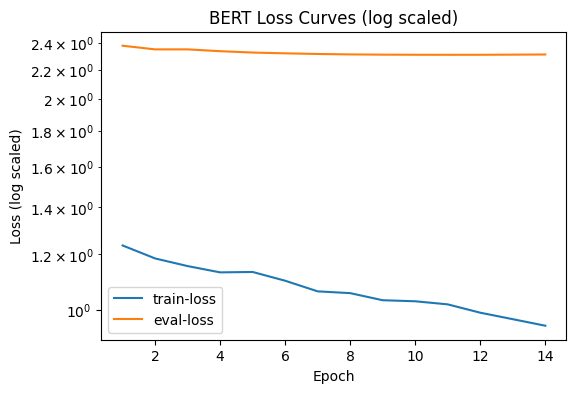

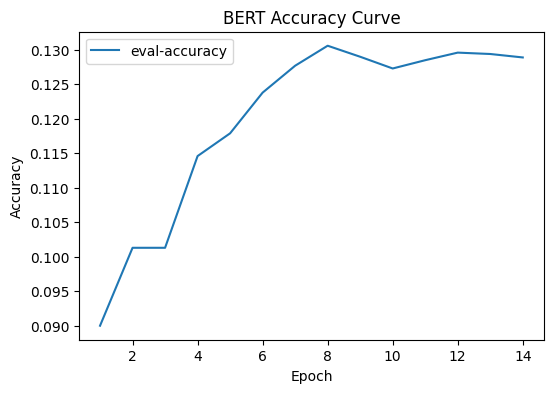

In [ ]:
# Collect logs ---------------------------------------------------------------
logs = trainer.state.log_history
train_loss, eval_loss, eval_acc, steps_eval, steps_train = [], [], [], [], []

for e in logs:
    if 'loss' in e and e.get("epoch") is not None:
        train_loss.append(e['loss'])
        steps_train.append(e['epoch'])
    if 'eval_loss' in e:
        eval_loss.append(e['eval_loss'])
        eval_acc.append(e['eval_accuracy'])
        steps_eval.append(e['epoch'])

# Plot -----------------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(steps_train, train_loss, label="train-loss")
plt.plot(steps_eval, eval_loss, label="eval-loss")
plt.yscale('log')
plt.xlabel("Epoch"); plt.ylabel("Loss (log scaled)"); plt.legend(); plt.title("BERT Loss Curves (log scaled)")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(steps_eval, eval_acc, label="eval-accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("BERT Accuracy Curve")
plt.show()




We can observe the following things from these plots and logs.

- The training loss decreases slightly but steadily, from about 1.14 to 1. This indicates there seems to be some kind of fitting to the training data. The small change in loss is expected due to the tiny dataset.
- However, the evaluation loss decreases slightly in the beginnning but then seems to flatten after some time - We are then early stopping to prevent more harmful adjustments of the parameters. Could be that we are **overfitting**! The 32 examples we have probably do not (evenly) represent all 10 classes. Let's check this out with a confusion matrix:



**Confusion Matrix**

In [ ]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
small_eval = dataset["test"].select(range(1000))
preds = trainer.predict(small_eval)

# Predict on test set
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)
print(train_dataset)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Dataset({
    features: ['id', 'topic', 'question_title', 'question_content', 'best_answer', '__index_level_0__'],
    num_rows: 32
})


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


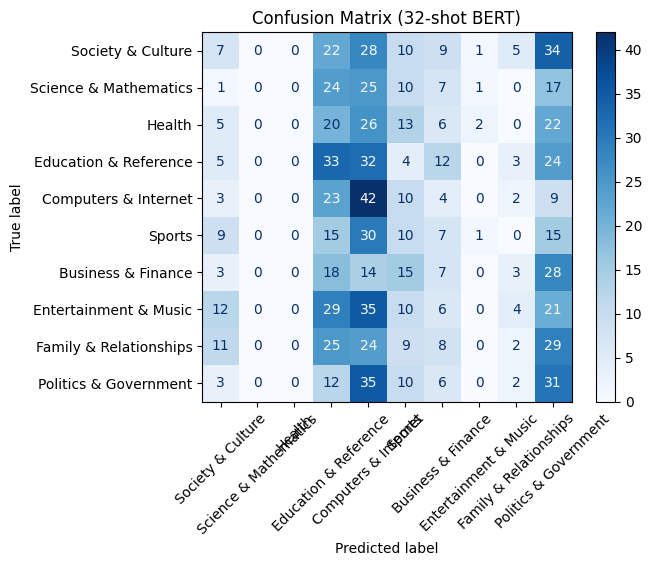

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
small_eval = dataset["test"].select(range(1000))
preds = trainer.predict(small_eval)
# Predict on test set
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)

label_names = class_names
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix (32-shot BERT)")
plt.show()


This confirms our suspicion:

The model over relies on a few classes like `Computers & Internet` and `Education & Referenc` which lead to poor generalization.
For example, we see how 28 out of 113 `Society & Culture` got predicted as  `Computers & Internet`and 22 more as `Education & Reference`.
24 `Science & Mathematics` got predicted as `Education & Reference`.


We can further analyze this with the classification report below.

**Report**

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=label_names))


                        precision    recall  f1-score   support

     Society & Culture       0.12      0.06      0.08       116
 Science & Mathematics       0.00      0.00      0.00        85
                Health       0.00      0.00      0.00        94
 Education & Reference       0.15      0.29      0.20       113
  Computers & Internet       0.14      0.45      0.22        93
                Sports       0.10      0.11      0.11        87
    Business & Finance       0.10      0.08      0.09        88
 Entertainment & Music       0.00      0.00      0.00       117
Family & Relationships       0.10      0.02      0.03       108
 Politics & Government       0.13      0.31      0.19        99

              accuracy                           0.13      1000
             macro avg       0.08      0.13      0.09      1000
          weighted avg       0.08      0.13      0.09      1000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- Firstly, the overaall accuracy is as depicted in the plot.
- This is only slightly above the **random baseline** 10%. It furthermore confirms the inability to generalize very well.
- The high recall of 0.45 shows that the model predicts `Computers & Internet` for almost everything as we discussed earlier.
- We also have zero precision and recall for many other classes, indicating that some classes are never predicted at all.
  

Label counts: 32
[4, 0, 2, 3, 6, 4, 3, 3, 3, 4]


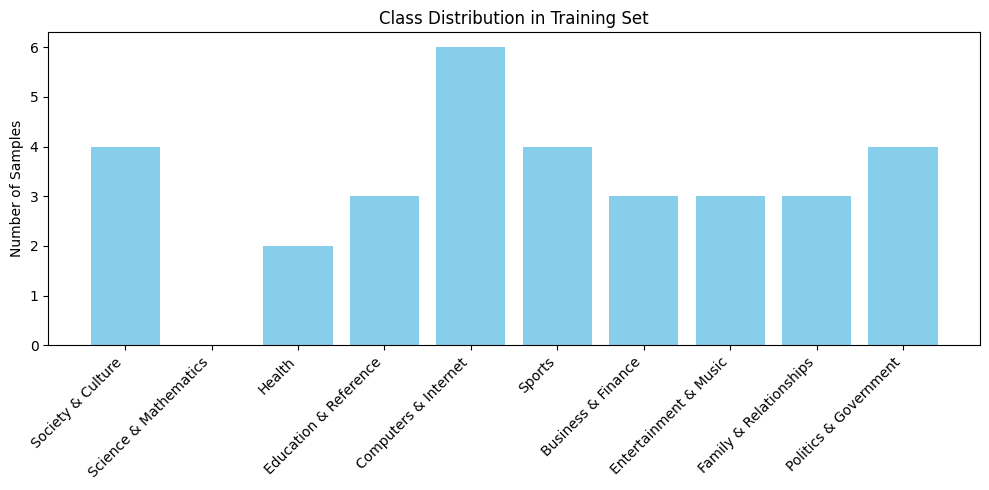

In [ ]:
labels_list = dataset["train"]["labels"].tolist()

print("Label counts:", len(labels_list))
label_counts = Counter(labels_list)
counts = [label_counts[i] for i in range(len(label_names))]
print(counts)
plt.figure(figsize=(10, 5))
plt.bar(label_names, counts, color="skyblue")
plt.xticks(rotation=45, ha='right')
plt.title("Class Distribution in Training Set")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.show()

We can clearly see that the classes `Computers & Internet` and `Society & Culture` are overrepresented, and `Science & Mathematics` is not present at all! Thus, the model has no chance to learn about `Health`!

To adress this, we will train the model again with the same parameters but using a stratified traiing dataset.
This will be done in the section below.

---
POL

In [20]:
dataset["train"]

Dataset({
    features: ['id', 'labels', 'question_title', 'best_answer', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 32
})

In [21]:
model_finetuned = model

# EXTRACT EMBEDDINGS AFTER FINE‐TUNING
embeddings_after, labels_after = get_cls_embeddings(model_finetuned, dataset['train'])

Extracting embeddings:   0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-15-1056582901>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids      = torch.tensor(example["input_ids"]).unsqueeze(0).to(model.device)
<ipython-input-15-1056582901>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(example["attention_mask"]).unsqueeze(0).to(model.device)
<ipython-input-15-1056582901>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  token_type_ids = torch.tensor(example["token_type_ids"]).unsqueeze(0).to(m

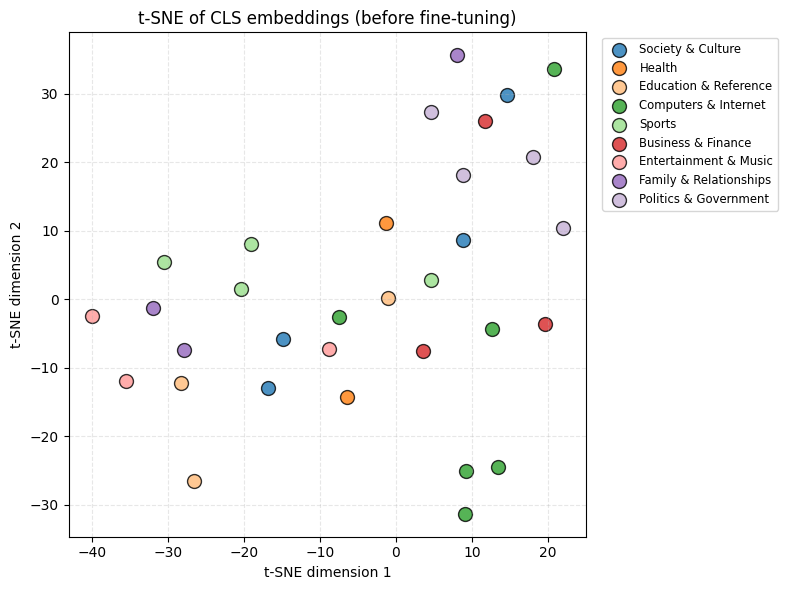

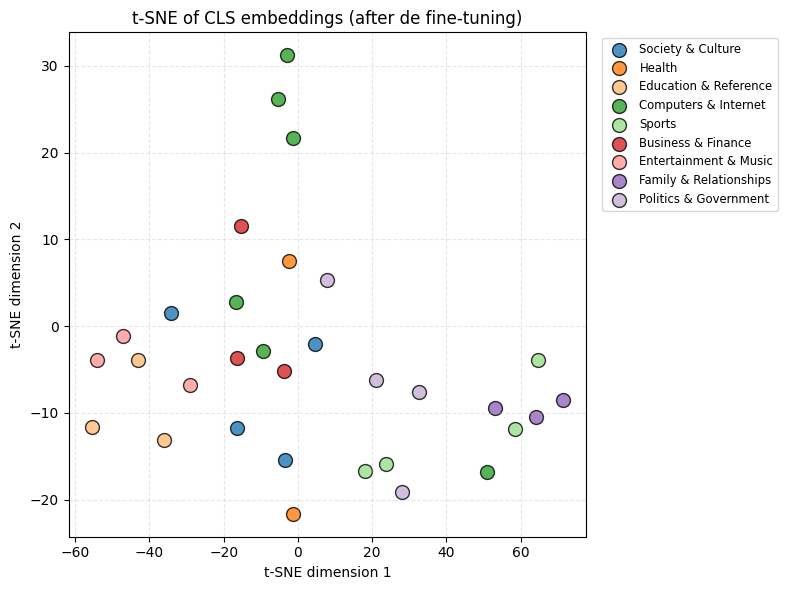

In [ ]:
# Reduce  2D with t-SNE
tsne = TSNE(n_components=2, perplexity=5, random_state=42)

X2_before = tsne.fit_transform(embeddings_before)  # (32, 2)
X2_after  = tsne.fit_transform(embeddings_after)   #  (32, 2) N=32
label_names = class_names

def plot_tsne_2d(X2, labels, label_names, title):
    """
    X2: array of  forma (N, 2)
    labels: array (N,)
    label_names: list of the names
    title: title for the plot
    """
    plt.figure(figsize=(8, 6))

    #generate plots
    num_classes = len(label_names)
    cmap = plt.get_cmap("tab20")
    colors = [cmap(i) for i in range(num_classes)]


    for class_id in range(num_classes):
        idxs = np.where(labels == class_id)[0]
        if len(idxs) == 0:
            continue
        plt.scatter(
            X2[idxs, 0],
            X2[idxs, 1],
            c=[colors[class_id]],
            label=label_names[class_id],
            s=100,
            alpha=0.8,
            edgecolors="k"
        )

    plt.title(title)
    plt.xlabel("t-SNE dimension 1")
    plt.ylabel("t-SNE dimension 2")
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize="small")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()


# Plot before and plot afer FT
plot_tsne_2d(
    X2_before,
    labels,
    label_names,
    title="t-SNE of CLS embeddings (before fine-tuning)"
)

plot_tsne_2d(
    X2_after,
    labels,
    label_names,
    title="t-SNE of CLS embeddings (after de fine-tuning)"
)


t-SNE (t-distributed Stochastic Neighbor Embedding) is a nonlinear dimensionality-reduction technique that projects high-dimensional data into two or three dimensions by modeling pairwise similarities: it converts distances into probabilities, preserves local neighborhood structure, and uses a heavy-tailed Student's t-distribution in the low-dimensional space to prevent points from crowding together.

We only use it to plot the embeddings to a 2D space where we can visually see how the fine-tuning afect to the embeddings fo the 32 labeled examples.

From this plot, it's not immediately obvious what the model has learned, especially given that it was trained on only 32 examples. However, when using the cross-entropy loss function, we expect the embeddings to become approximately **linearly separable by class**.

The model learns to shape the embedding space so that the [CLS] vector produces high logits for the correct class. This is why we start to see that, in some dimensions, embeddings with the same label become closer together, while the distance between embeddings of different classes increases. The better this separation, the lower the loss. This explains why we can begin to observe some structural rearrangement in the 2D projection of the embeddings.

Lets analyze the 32 labeled questions that has beeing used for training,

In [ ]:
ep_df = observation_training.to_pandas()
print(ep_df[['topic', 'question_content']])
print(label_names)

    topic                                   question_content
0       3     i can't figure it out and it's been bugging me
1       3  be specific add details a bout the book im ask...
2       3  Tell me The What is it, What attributes does i...
3       9  What is your favorite speech or quote? Wheneve...
4       4  I ahve a trojan that causes so many pop-up to ...
5       4  Dell OPTIPLEX GX100\n64 bit bus\n100Mhz mem\nP...
6       0  I am writing a short story and I have to addre...
7       0                                             person
8       4  is there a such program and if so what is the ...
9       4  whenevr I try to open Explorer I get the follo...
10      4  Want to create a cd that opens like a web site...
11      9  I am very glad if you can tell me some specifi...
12      9  Playing devils advocate here, whilst i persona...
13      2  i have never gotten my period, but my mom alwa...
14      4  Displayed same image on both monitors but coul...
15      0               

By observing the questions, we notice that even within the same topic, the structure and formulation of the questions can vary significantly, and no obvious pattern emerges. However, after training the model, we observe that in some topics, the embeddings of related questions begin to move closer together. This suggests that the model is starting to capture not just surface-level similarities in wording, but also the deeper context and semantic content of the questions.

Importantly, this effect cannot be attributed solely to similar question formulations. In several cases, we see that questions from the same topic were initially far apart in the embedding space, likely due to differences in their phrasing or structure, but became closer after even a small amount of training. This indicates that the model may be beginning to learn topic-level semantics and contextual relationships between questions, beyond just superficial patterns.




### 32 Shot 2.0 (stratified 32 samples)

Since we reuse most of the code from above, we skip explanations and put the stratification in one chunk and all the rest into another.

In [22]:
stratified_train_df, stratified_test_df = train_test_split(
    df,
    train_size=32,
    stratify=df["topic"],
    random_state=42
)

stratified_train_dataset = Dataset.from_pandas(stratified_train_df)
stratified_test_dataset  = Dataset.from_pandas(stratified_test_df.sample(n=10000, random_state=42))  # cap for efficiency

dataset = DatasetDict({
    'train': stratified_train_dataset,
    'test': stratified_test_dataset
})

model_ckpt   = "bert-base-uncased"
num_labels   = 10
max_length   = 128                   # truncate / pad length
batch_size   = 100
seed         = 42

def set_seed(seed):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(seed)


tok = AutoTokenizer.from_pretrained(model_ckpt)

# Tokeniser
def tokenize(batch):
    return tok(batch["question_content"], padding="max_length", truncation=True, max_length=128)

dataset = dataset.map(tokenize, batched=True, remove_columns=["question_content"])
dataset = dataset.rename_column("topic", "labels")

dataset.set_format("torch")


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels = num_labels,
    problem_type = "single_label_classification"
)

metric_accuracy  = evaluate.load("accuracy")
metric_precision = evaluate.load("precision")
metric_recall    = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc  = metric_accuracy.compute(predictions=preds, references=labels)
    prec = metric_precision.compute(predictions=preds, references=labels, average="macro")
    rec  = metric_recall.compute(predictions=preds, references=labels, average="macro")

    # merge into a single dict that Trainer can log
    return {
        "accuracy":  acc["accuracy"],
        "precision": prec["precision"],
        "recall":    rec["recall"],
    }

args = TrainingArguments(
    output_dir          = "./yahoo-bert-32shot-stratified",
    eval_strategy       = "epoch",
    save_strategy       = "epoch",
    logging_strategy    = "epoch", #FIXED TO SEE LOGGING
    #logging_steps       = 50,
    learning_rate       = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size  = batch_size,
    num_train_epochs    = 20,
    weight_decay        = 0.01,
    load_best_model_at_end = True,
    metric_for_best_model = "eval_loss",
    save_total_limit    = 2,
    seed                = seed,
    report_to           = "none",  # Disable wandb
    fp16                = True, # Enable mixed precision training
    gradient_accumulation_steps = 2
)

trainer = Trainer(
    model           = model,
    args            = args,
    train_dataset   = dataset["train"],
    eval_dataset    = dataset["test"],  # small held-out set for early-stop
    compute_metrics = compute_metrics,
    callbacks       = [EarlyStoppingCallback(early_stopping_patience=3)]
)
train_output = trainer.train("yahoo-bert-32shot-stratified/checkpoint-13")#remove string to train from scratch
trainer.push_to_hub("yahoo-bert-32shot_strat")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/otausendschoen/yahoo-bert-32shot-stratified/commit/2dbfa87d9ccaeba45446bb2996bdb93f76250d11', commit_message='yahoo-bert-32shot_strat', commit_description='', oid='2dbfa87d9ccaeba45446bb2996bdb93f76250d11', pr_url=None, repo_url=RepoUrl('https://huggingface.co/otausendschoen/yahoo-bert-32shot-stratified', endpoint='https://huggingface.co', repo_type='model', repo_id='otausendschoen/yahoo-bert-32shot-stratified'), pr_revision=None, pr_num=None)

In [ ]:
trainer.state.log_history

[{'epoch': 1.0,
  'grad_norm': 1.90114164352417,
  'learning_rate': 2e-05,
  'loss': 1.1876,
  'step': 1},
 {'epoch': 1.0,
  'eval_accuracy': 0.0946,
  'eval_loss': 2.3661277294158936,
  'eval_precision': 0.06496459968085506,
  'eval_recall': 0.10131696897392437,
  'eval_runtime': 14.0966,
  'eval_samples_per_second': 709.392,
  'eval_steps_per_second': 7.094,
  'step': 1},
 {'epoch': 2.0,
  'grad_norm': 1.5268402099609375,
  'learning_rate': 1.9e-05,
  'loss': 1.158,
  'step': 2},
 {'epoch': 2.0,
  'eval_accuracy': 0.0989,
  'eval_loss': 2.347957134246826,
  'eval_precision': 0.10794365523762088,
  'eval_recall': 0.1056516237206955,
  'eval_runtime': 14.3258,
  'eval_samples_per_second': 698.042,
  'eval_steps_per_second': 6.98,
  'step': 2},
 {'epoch': 3.0,
  'grad_norm': 1.3485993146896362,
  'learning_rate': 1.8e-05,
  'loss': 1.1027,
  'step': 3},
 {'epoch': 3.0,
  'eval_accuracy': 0.105,
  'eval_loss': 2.3340723514556885,
  'eval_precision': 0.1324075335113453,
  'eval_recall': 0

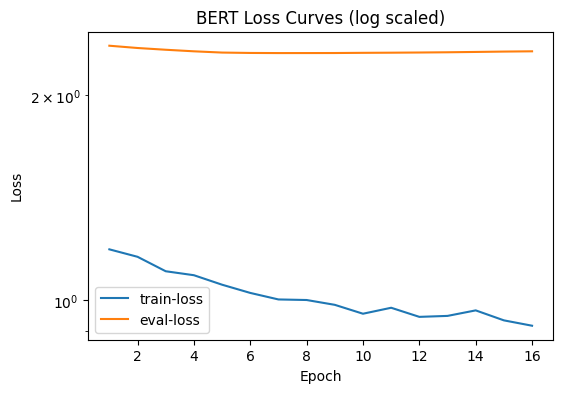

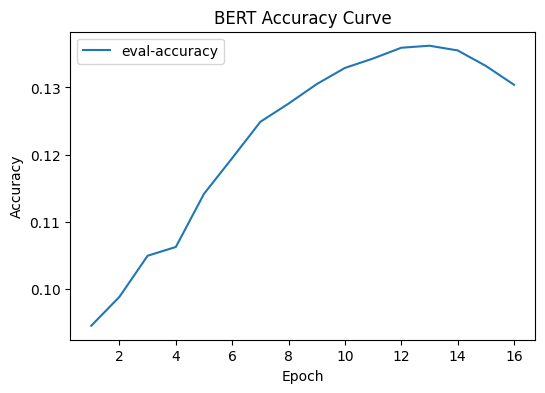

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


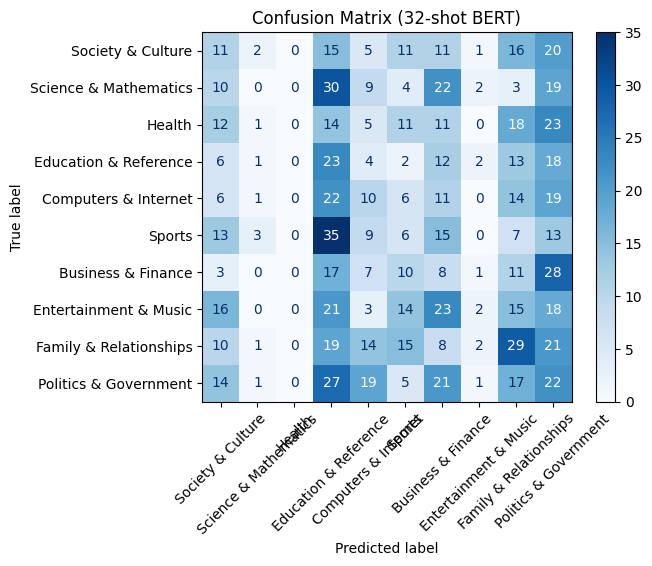

In [ ]:
# Collect logs
logs = trainer.state.log_history
train_loss, eval_loss, eval_acc, steps_eval, steps_train = [], [], [], [], []

for e in logs:
    if 'loss' in e and e.get("epoch") is not None:
        train_loss.append(e['loss'])
        steps_train.append(e['epoch'])
    if 'eval_loss' in e:
        eval_loss.append(e['eval_loss'])
        eval_acc.append(e['eval_accuracy'])
        steps_eval.append(e['epoch'])

# Plot
plt.figure(figsize=(6,4))
plt.plot(steps_train, train_loss, label="train-loss")
plt.plot(steps_eval, eval_loss, label="eval-loss")
plt.xlabel("Epoch"); plt.yscale("log");plt.ylabel("Loss"); plt.legend(); plt.title("BERT Loss Curves (log scaled)")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(steps_eval, eval_acc, label="eval-accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("BERT Accuracy Curve")
plt.show()



from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
small_eval = dataset["test"].select(range(1000))
preds = trainer.predict(small_eval)
# Predict on test set
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)

label_names = class_names
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix (32-shot BERT)")
plt.show()


Interestingly, this time the model early stops at epoch 16. Looking at the updated loss plot, we can observe the following improvements:

- The training loss again decreases steadily but also seems to stabilize/flatten.



With the confusion matrix, we can confirm that the model generalizes better or that there is not such a big imbalance anymore.
While there is still a tendency toward some dominant classes, this distribution is a clear step forward from the earlier imbalance!

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=label_names))


                        precision    recall  f1-score   support

     Society & Culture       0.11      0.12      0.11        92
 Science & Mathematics       0.00      0.00      0.00        99
                Health       0.00      0.00      0.00        95
 Education & Reference       0.10      0.28      0.15        81
  Computers & Internet       0.12      0.11      0.11        89
                Sports       0.07      0.06      0.06       101
    Business & Finance       0.06      0.09      0.07        85
 Entertainment & Music       0.18      0.02      0.03       112
Family & Relationships       0.20      0.24      0.22       119
 Politics & Government       0.11      0.17      0.13       127

              accuracy                           0.11      1000
             macro avg       0.10      0.11      0.09      1000
          weighted avg       0.10      0.11      0.09      1000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Overall, we can see:

- The overall accuracy increased seems to has **improved slightly**, but it is still at about 13%. However, most importantly, the result is more stable which is why we should use this as our final baseline BERT model. We note that we archieve about **13.3%** accuracy, not much better than our 10% baseline but expected due to the limited sample size!


## b) Dataset Augmenation

We will implement an automated data augmentation technique based on Masked Language Modeling (MLM) using BERT.

We use the fill-mask pipeline from Hugging Face, which utilizes BERT to predict missing words in masked sentences.

The augmentation process works as follows:

- For each sentence in the training set, we randomly select a word to mask. We will do this with one masked token first. We shall also see if results get better if we use 3 masked tokes.

- BERT is then used to predict the most likely replacement for the masked word.

- The resulting sentence is treated as a new augmented example, preserving the original label.

- Finally, we combine the original and augmented samples into a new training set and retrain the model.



### 1 Masked Token Prediction

In [23]:
stratified_train_df, stratified_test_df = train_test_split(
    df,
    train_size=32,
    stratify=df["topic"],
    random_state=42
)


fill_mask = pipeline("fill-mask", model="bert-base-uncased")

def augment_sentence(sentence, top_k=3):
    words = sentence.split()
    if len(words) < 3:
        print(f"[SKIP] Too short: {sentence}")
        return []

    candidate_indices = [i for i, w in enumerate(words) if w.isalpha()]
    if not candidate_indices:
        print(f"[SKIP] No valid words to mask: {sentence}")
        return []

    idx = random.choice(candidate_indices)
    original_word = words[idx]
    words[idx] = '[MASK]'
    masked_sentence = ' '.join(words)
    print(f"[INFO] Masked '{original_word}' → {masked_sentence}")

    try:
        predictions = fill_mask(masked_sentence, top_k=top_k)
    except Exception as e:
        print(f"[ERROR] BERT prediction failed: {e}")
        return []

    augmented = []
    for p in predictions:
        filled_sentence = masked_sentence.replace('[MASK]', p['token_str'])
        if filled_sentence.strip() != sentence.strip():
            print(f"[AUG] {filled_sentence}")
            augmented.append(filled_sentence)
        else:
            print(f"[NO CHANGE] {filled_sentence}")
    return augmented

# Apply to training data
augmented_rows = []
for i, (text, label) in enumerate(zip(stratified_train_df["question_content"], stratified_train_df["topic"])):
    print(f"\n Original [{i}]: {text}")
    new_sentences = augment_sentence(text, top_k=3)
    for aug in new_sentences:
        augmented_rows.append({
            "question_content": aug,
            "topic": label
        })

# Final check: how many augmented examples?
df_aug = pd.DataFrame(augmented_rows)
print(f"\n Augmentation complete: {len(df_aug)} new examples generated.")


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0



 Original [0]: Il a préféré s'absenter au 3e  match decésif,offerant ainsi l'occasion à son entraineur d'inclure élément prévisible ce qui ameliorerait  attaque.Baravo mestro.C'est trés intelligent. \nJe parie  que les bleus irront  plus loin,ils vont molo molo mais bien; il ne résterait que l'arbitrage soit meilleur.Hurlons fort  pour que l'usage de la védio soit pratiqué et pas jusqu'à ce que les choses s'agraveraient ,ce qui ne désantagerait plus les équipes,car tout compte au sport,la moiondre des erreurs fausserait le résultat réel.Nous payons et nous devrons etre ecoute par ceux qui ne cherchent que le profit.C'est de notre doit de protéster si non bouicotons .Tous moyens materiels corréctionnels  sont fiables.Ns serrions moins bruillants  et moins provoqués car nous admettrons le résultat final.Réveillons nous chers partisants du fair play.Assez qu'on ns fait passer pour des naifs et contribuons à l'amelioration des disciplines car nous finançons   pour se relaxer et non pour e

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


[NO CHANGE] This is for a statistics class, so please answer these.\n\n1.What is your favorite computer brand?\n\n1.What is your favorite B name?\n\n1.How many kids do you have?\n\n(if you answer any 1-2 questions please answer both)\n\n1.Whis is your shoe size?\n\n2.How tall are you?\n\n1. How many tv's are in your house?\n\n2. how many rooms are in your house?\n\n1. How many kids do you want?\n\n2. how many pets do you want?\n\n\nthank you
[AUG] This is for a statistics class, so please answer these.\n\n1.What was your favorite computer brand?\n\n1.What is your favorite B name?\n\n1.How many kids do you have?\n\n(if you answer any 1-2 questions please answer both)\n\n1.Whis is your shoe size?\n\n2.How tall are you?\n\n1. How many tv's are in your house?\n\n2. how many rooms are in your house?\n\n1. How many kids do you want?\n\n2. how many pets do you want?\n\n\nthank you
[AUG] This is for a statistics class, so please answer these.\n\n1.What about your favorite computer brand?\n\n1.

From the output, we can see exactly what happens. the [INFO] row contains info on what is masked and the [AUG] row the resulting synthetic sentence. If there happens to be no change, we mark it as [NO CHANGE]:

This choose this method because:
- We retains label alignment
- We introduce some lexical diversity
- Lightweight: We do not rely on large generative LLMs (GPT, Mistral, etc.)

However, from the output we can also see a bunch of limitations:

- Replacements are **limited to single-token substitutions**
- There occasionally appear **ungrammatical or semantically awkward** variants
- Context is preserved only **locally** (BERT doesn't "rethink" the full sentence)

Overall, we generated **N = 78** new examples. This might not seem like a lot but in relative terms, it enables us to work with 200% more data. It should thus be enough to see if it improves or worsens our classification.

### 3 Masked Token Prediction

In [ ]:
df_combined = pd.concat([df_aug, stratified_train_df])

In [ ]:

stratified_train_df, stratified_test_df = train_test_split(
    df,
    train_size=32,
    stratify=df["topic"],
    random_state=42
)

fill_mask = pipeline("fill-mask", model="bert-base-uncased")


def augment_sentence_multi_mask(sentence, top_k=3, num_masks=3):
    words = sentence.split()
    if len(words) < num_masks:
        print(f"[SKIP] Too short: {sentence}")
        return []

    candidate_indices = [i for i, w in enumerate(words) if w.isalpha()]
    if len(candidate_indices) < num_masks:
        print(f"[SKIP] Not enough maskable words: {sentence}")
        return []

    # Choose num_masks unique indices
    mask_indices = random.sample(candidate_indices, num_masks)
    mask_tokens = [f'[MASK{i+1}]' for i in range(num_masks)]

    original_words = [words[idx] for idx in mask_indices]
    for i, idx in enumerate(mask_indices):
        words[idx] = mask_tokens[i]

    masked_sentence = ' '.join(words)
    print(f"[INFO] Masked {original_words} → {masked_sentence}")

    # Predict each mask separately
    filled = {}
    for i, token in enumerate(mask_tokens):
        sentence_with_single_mask = masked_sentence.replace(token, '[MASK]')
        try:
            preds = fill_mask(sentence_with_single_mask, top_k=top_k)
        except Exception as e:
            print(f"[ERROR] BERT failed on {token}: {e}")
            return []

        filled[token] = [p['token_str'] for p in preds]

    # Generate all combinations (1 from each mask's predictions)
    from itertools import product
    augmented = []
    for combination in product(*filled.values()):
        temp = masked_sentence
        for token, replacement in zip(mask_tokens, combination):
            temp = temp.replace(token, replacement)
        if temp.strip() != sentence.strip():
            print(f"[AUG] {temp}")
            augmented.append(temp)
        else:
            print(f"[NO CHANGE] {temp}")

    return augmented

augmented_rows = []
for i, (text, label) in enumerate(zip(stratified_train_df["question_content"], stratified_train_df["topic"])):
    print(f"\n Original [{i}]: {text}")
    new_sentences = augment_sentence_multi_mask(text, top_k=2, num_masks=3)
    for aug in new_sentences:
        augmented_rows.append({
            "question_content": aug,
            "topic": label
        })

df_aug = pd.DataFrame(augmented_rows)
print(f"\nAugmentation complete: {len(df_aug)} new examples generated.")


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Device set to use cuda:0



 Original [0]: Il a préféré s'absenter au 3e  match decésif,offerant ainsi l'occasion à son entraineur d'inclure élément prévisible ce qui ameliorerait  attaque.Baravo mestro.C'est trés intelligent. \nJe parie  que les bleus irront  plus loin,ils vont molo molo mais bien; il ne résterait que l'arbitrage soit meilleur.Hurlons fort  pour que l'usage de la védio soit pratiqué et pas jusqu'à ce que les choses s'agraveraient ,ce qui ne désantagerait plus les équipes,car tout compte au sport,la moiondre des erreurs fausserait le résultat réel.Nous payons et nous devrons etre ecoute par ceux qui ne cherchent que le profit.C'est de notre doit de protéster si non bouicotons .Tous moyens materiels corréctionnels  sont fiables.Ns serrions moins bruillants  et moins provoqués car nous admettrons le résultat final.Réveillons nous chers partisants du fair play.Assez qu'on ns fait passer pour des naifs et contribuons à l'amelioration des disciplines car nous finançons   pour se relaxer et non pour e

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


[AUG] Il a préféré s'absenter au 3e match decésif,offerant ainsi l'occasion à son entraineur d'inclure élément prévisible ce qui ameliorerait attaque.Baravo mestro.C'est trés intelligent. \nJe parie que les bleus irront plus loin,ils vont molo molo mais bien; il ne résterait que l'arbitrage soit meilleur.Hurlons fort pour que l'usage de la védio soit pratiqué et pas jusqu'à ce qui les choses s'agraveraient ,ce qui ne désantagerait plus les équipes,car tout compte au sport,la moiondre . erreurs fausserait le résultat réel.Nous payons et nous devrons etre ecoute par ceux qui ne cherchent que le profit.C'est de notre doit de protéster si non bouicotons .Tous moyens materiels corréctionnels sont fiables.Ns serrions moins bruillants et moins provoqués car nous admettrons le résultat final.Réveillons nous chers partisants du sport play.Assez qu'on ns fait passer pour des naifs et contribuons à l'amelioration des disciplines car nous finançons pour se relaxer et non pour etre volé .
[AUG] Il 

Instead of masking a **single word**, we now mask **three different tokens** per sentence and generate variations for each. This results in a **richer and more diverse** synthetically created sample set.

- We increase **lexical diversity** more than in the 1-mask case and simulate richer variation.
- It remains **lightweight and label-consistent**, using only a pretrained `bert-base-uncased`.
- We **do not mask the final token** in the sentence, as punctuation like `?` or `.` is often semantically and syntactically crucial, especially for questions.

With this method, we generated a total of **229 new examples**, almost **8× our original 32-sample training set**.

Most augmented sentences preserve the core meaning and grammaticality. For example:
Original: I do not want this stuff or want to look at this stuff.
Augmented: I do not want that stuff or want to look at this stuff.


This maintains the intent while increasing lexical variety.

However, some generations suffer from:
- **Syntactic breakdowns** (e.g., misplaced punctuation)
- **Fluency issues** (e.g., removing or replacing auxiliary verbs or determiners)
- **Semantic drift** (changing the meaning subtly or significantly)

For examüple:  
- `"He likes Kantucky , but he has a lot of that to help me..."`  
  → Broken structure due to inappropriate placement of a phrase fragment.

- `"im only gaining weight from your face..."`  
  → Semantic confusion: “your face” alters the meaning completely.



While not every generated sentence is perfect, it seems that this **expands the dataset** and introduces **controlled diversity**. As long as the label remains valid, this technique can be a powerful data augmentation method. We will now check if this is the case or if it makes our model worse.


In [24]:
df_combined_3 = pd.concat([df_aug, stratified_train_df])

### Model Training

In [ ]:

train_dataset = Dataset.from_pandas(df_combined)
test_dataset  = Dataset.from_pandas(stratified_test_df.sample(n=10000, random_state=42))  # cap for efficiency

dataset = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})


model_ckpt   = "bert-base-uncased"   # ✔️ swap for "microsoft/MiniLM-L6..." if you need something lighter
num_labels   = 10
max_length   = 128                   # truncate / pad length
batch_size   = 100
seed         = 42

def set_seed(seed):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(seed)


tok = AutoTokenizer.from_pretrained(model_ckpt)

# Tokeniser -------------------------------------------------------------------
def tokenize(batch):
    return tok(batch["question_content"], padding="max_length", truncation=True, max_length=128)

dataset = dataset.map(tokenize, batched=True, remove_columns=["question_content"])
dataset = dataset.rename_column("topic", "labels")

dataset.set_format("torch")

Map:   0%|          | 0/110 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels = num_labels,
    problem_type = "single_label_classification"
)

metric_accuracy  = evaluate.load("accuracy")
metric_precision = evaluate.load("precision")
metric_recall    = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc  = metric_accuracy.compute(predictions=preds, references=labels)
    prec = metric_precision.compute(predictions=preds, references=labels, average="macro")
    rec  = metric_recall.compute(predictions=preds, references=labels, average="macro")

    # merge into a single dict that Trainer can log
    return {
        "accuracy":  acc["accuracy"],
        "precision": prec["precision"],
        "recall":    rec["recall"],
    }

args = TrainingArguments(
    output_dir          = "./yahoo-bert-32shot-stratified_augm",
    eval_strategy       = "epoch",
    save_strategy       = "epoch",
    logging_strategy    = "epoch", #FIXED TO SEE LOGGING
    #logging_steps       = 50,
    learning_rate       = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size  = batch_size,
    num_train_epochs    = 20,
    weight_decay        = 0.01,
    load_best_model_at_end = True,
    metric_for_best_model = "eval_loss",
    save_total_limit    = 2,
    seed                = seed,
    report_to           = "none",  # Disable wandb
    fp16                = True, # Enable mixed precision training
    gradient_accumulation_steps = 2
)

trainer = Trainer(
    model           = model,
    args            = args,
    train_dataset   = dataset["train"],
    eval_dataset    = dataset["test"],  # small held-out set for early-stop
    compute_metrics = compute_metrics,
    callbacks       = [EarlyStoppingCallback(early_stopping_patience=3)]
)
train_output = trainer.train()#remove string to train from scratch
trainer.push_to_hub("yahoo-bert-32shot_strat_augm")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/otausendschoen/yahoo-bert-32shot-stratified_augm/commit/eead34afc9a3e518af2769474cd645830fb44fb9', commit_message='yahoo-bert-32shot_strat_augm', commit_description='', oid='eead34afc9a3e518af2769474cd645830fb44fb9', pr_url=None, repo_url=RepoUrl('https://huggingface.co/otausendschoen/yahoo-bert-32shot-stratified_augm', endpoint='https://huggingface.co', repo_type='model', repo_id='otausendschoen/yahoo-bert-32shot-stratified_augm'), pr_revision=None, pr_num=None)

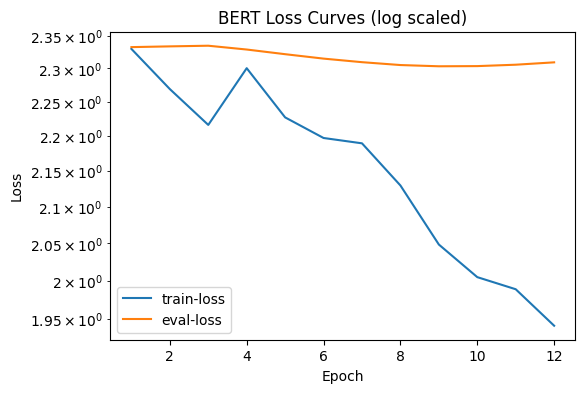

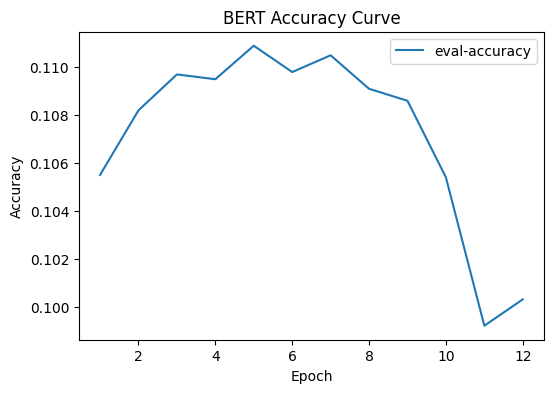

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


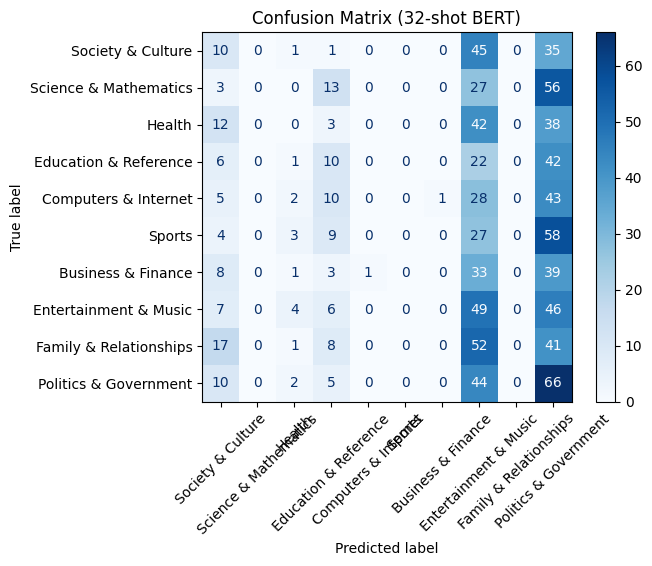

In [ ]:
# Collect logs ---------------------------------------------------------------
logs = trainer.state.log_history
train_loss, eval_loss, eval_acc, steps_eval, steps_train = [], [], [], [], []

for e in logs:
    if 'loss' in e and e.get("epoch") is not None:
        train_loss.append(e['loss'])
        steps_train.append(e['epoch'])
    if 'eval_loss' in e:
        eval_loss.append(e['eval_loss'])
        eval_acc.append(e['eval_accuracy'])
        steps_eval.append(e['epoch'])

# Plot -----------------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(steps_train, train_loss, label="train-loss")
plt.plot(steps_eval, eval_loss, label="eval-loss")
plt.xlabel("Epoch"); plt.yscale("log");plt.ylabel("Loss"); plt.legend(); plt.title("BERT Loss Curves (log scaled)")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(steps_eval, eval_acc, label="eval-accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("BERT Accuracy Curve")
plt.show()



from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
small_eval = dataset["test"].select(range(1000))
preds = trainer.predict(small_eval)
# Predict on test set
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)

label_names = class_names
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix (32-shot BERT)")
plt.show()


After training the model wiht augmentation using 1 Mask prediciton, we can observe the following:

- Accuracy does not improve compared to our non-augmented model. Even after 12 epochs, the model achieves an evaluation accuracy of only around 10%, which is roughly random chance given the 10-way classification. This indicates that the augmented data does not help—and might even hurt—generalization.


- One possible reason is that the synthetically generated samples introduce noise that confuses the model. While the original labels are preserved, the semantics of the sentence may be distorted, leading to a mismatch between input and target label.

- From the confusion matrix, we observe that the model heavily misclassifies across most categories, with a tendency to default to popular classes like Family & Relationships, Politics & Government, or Entertainment & Music. These classes appear as the most frequent predictions across almost all true labels.


We will run the 3 token mask model to see if and how this changes.

In [51]:
# tirdod start here

train_dataset = Dataset.from_pandas(df_combined_3)
test_dataset  = Dataset.from_pandas(stratified_test_df.sample(n=10000, random_state=42))  # cap for efficiency

dataset = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})


model_ckpt   = "bert-base-uncased"   # ✔️ swap for "microsoft/MiniLM-L6..." if you need something lighter
num_labels   = 10
max_length   = 128                   # truncate / pad length
batch_size   = 100
seed         = 42

def set_seed(seed):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(seed)


tok = AutoTokenizer.from_pretrained(model_ckpt)

# Tokeniser -------------------------------------------------------------------
def tokenize(batch):
    return tok(batch["question_content"], padding="max_length", truncation=True, max_length=128)

dataset = dataset.map(tokenize, batched=True, remove_columns=["question_content"])
dataset = dataset.rename_column("topic", "labels")

dataset.set_format("torch")

Map:   0%|          | 0/110 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [52]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels = num_labels,
    problem_type = "single_label_classification"
)

metric_accuracy  = evaluate.load("accuracy")
metric_precision = evaluate.load("precision")
metric_recall    = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc  = metric_accuracy.compute(predictions=preds, references=labels)
    prec = metric_precision.compute(predictions=preds, references=labels, average="macro")
    rec  = metric_recall.compute(predictions=preds, references=labels, average="macro")

    # merge into a single dict that Trainer can log
    return {
        "accuracy":  acc["accuracy"],
        "precision": prec["precision"],
        "recall":    rec["recall"],
    }

args = TrainingArguments(
    output_dir          = "./yahoo-bert-32shot-stratified_augm_2",
    eval_strategy       = "epoch",
    save_strategy       = "epoch",
    logging_strategy    = "epoch", #FIXED TO SEE LOGGING
    #logging_steps       = 50,
    learning_rate       = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size  = batch_size,
    num_train_epochs    = 20,
    weight_decay        = 0.01,
    load_best_model_at_end = True,
    metric_for_best_model = "eval_loss",
    save_total_limit    = 2,
    seed                = seed,
    report_to           = "none",  # Disable wandb
    fp16                = True, # Enable mixed precision training
    gradient_accumulation_steps = 2
)

trainer = Trainer(
    model           = model,
    args            = args,
    train_dataset   = dataset["train"],
    eval_dataset    = dataset["test"],  # small held-out set for early-stop
    compute_metrics = compute_metrics,
    callbacks       = [EarlyStoppingCallback(early_stopping_patience=3)]
)

train_output = trainer.train()

# Save fine-tuned model locally
trainer.save_model("./yahoo-bert-32shot_stratified_augm_2")

# Upload full model directory (includes config, tokenizer, AND weights)
repo_name = "tirdodbehbehani/yahoo-bert-32shot_stratified_augm_2"
api = HfApi()
api.upload_folder(
    folder_path="./yahoo-bert-32shot_stratified_augm_2",
    repo_id=repo_name,
    repo_type="model"
)

# Push tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
tokenizer.push_to_hub(repo_name)

# tirdod end here

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Uploading...:   0%|          | 0.00/438M [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/tirdodbehbehani/yahoo-bert-32shot_stratified_augm_2/commit/c12115f8c79c2ef774b2b3a99a0406237869beb4', commit_message='Upload tokenizer', commit_description='', oid='c12115f8c79c2ef774b2b3a99a0406237869beb4', pr_url=None, repo_url=RepoUrl('https://huggingface.co/tirdodbehbehani/yahoo-bert-32shot_stratified_augm_2', endpoint='https://huggingface.co', repo_type='model', repo_id='tirdodbehbehani/yahoo-bert-32shot_stratified_augm_2'), pr_revision=None, pr_num=None)

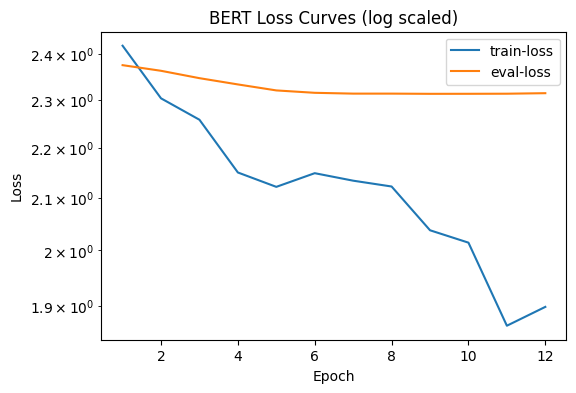

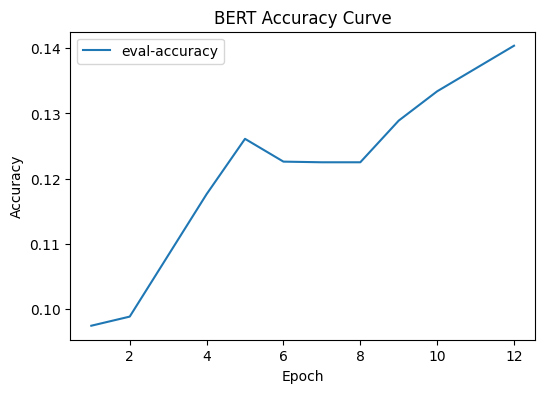

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


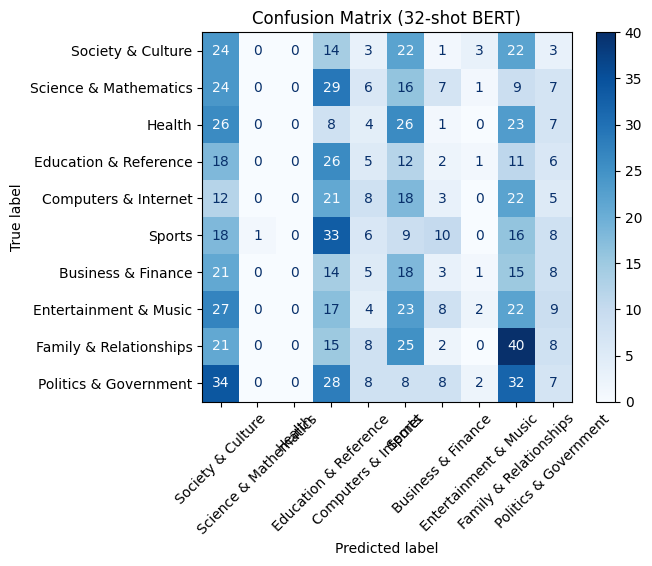

In [47]:
# Collect logs ---------------------------------------------------------------
logs = trainer.state.log_history
train_loss, eval_loss, eval_acc, steps_eval, steps_train = [], [], [], [], []

for e in logs:
    if 'loss' in e and e.get("epoch") is not None:
        train_loss.append(e['loss'])
        steps_train.append(e['epoch'])
    if 'eval_loss' in e:
        eval_loss.append(e['eval_loss'])
        eval_acc.append(e['eval_accuracy'])
        steps_eval.append(e['epoch'])

# Plot -----------------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(steps_train, train_loss, label="train-loss")
plt.plot(steps_eval, eval_loss, label="eval-loss")
plt.xlabel("Epoch"); plt.yscale("log");plt.ylabel("Loss"); plt.legend(); plt.title("BERT Loss Curves (log scaled)")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(steps_eval, eval_acc, label="eval-accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("BERT Accuracy Curve")
plt.show()



from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
small_eval = dataset["test"].select(range(1000))
preds = trainer.predict(small_eval)
# Predict on test set
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)

label_names = class_names
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix (32-shot BERT)")
plt.show()


From the new results, we observe the following:

- Evaluation accuracy improves noticeably, reaching over 15% after early stopping at 8 epochs. This is meaningful compared to the ~10% plateau seen in the single-token augmentation, suggesing that masking more tokens introduces enough variation to benefit generalization—at least to some extent. Otherwiske, this could also come from the fact that we generated more samples!

- Just like before, training loss continues to drop steadily, while evaluation loss remains relatively flat.

- In terms of the confusion matrix shows slightly more diversity in predicted labels, but the model still struggles to discriminate effectively across all 10 classes. However, compared to the 1-mask setting, there is now less dominance of a few classes like "Politics & Government" and "Family & Relationships", indicating a slightly better class balance in predictions.

- Nevertheless, just like before not all synthetic samples help. Some masked predictions e.g. replacing “happy and glad” with “begging asking happy
 2 show grammatical or semantic corruption. These cases likely introduce harmful noise.

Overall, we can say that we can observe some kind of trade-off: increasing the number of masked tokens may enhance diversity, which can help, but also raises the risk of introducing semantic changes. As shown in the confusion matrix, the 3-mask model performs better in classifying minority categories but still fails to produce sharply defined boundaries between classes.


To make this more concrete, we can observe the following when we compare the baseline model confusion matrix of the 32 shot model 2.0 to the new one here:

- In the baseline (non-augmented) model, classes like Family & Relationships and Politics & Government were over-predicted, often dominating rows across unrelated true labels.

-With 3-mask augmentation, the predictions become more correct (in some cases): for example, for Politics & Governements we got 51 correct labels versus 22 in the baseline model

- Importantly, it **does not seem like predictions got more balanced**. While overall accuracy increased, this imporvements came mainly from a few classes like improved correct predictions from politics and goverment.  We will thus try out to ensure a balanced augmented dataset to see if it helps.

Minimum class count: 4


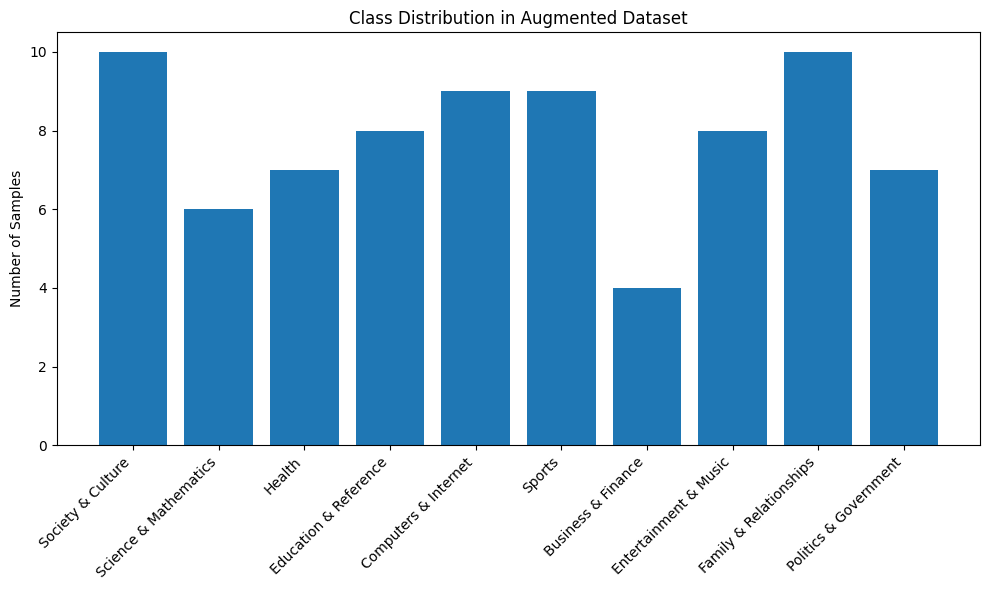

In [48]:
# Descriptive statistics
dataset_size = len(df_aug)
class_distribution = df_aug['topic'].value_counts().sort_index()
min_count = df_aug['topic'].value_counts().min()
print("Minimum class count:", min_count)
plt.figure(figsize = (10,6))
plt.bar(class_names, class_distribution)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Augmented Dataset")
plt.tight_layout()


In [ ]:
df_aug_stratified = (
    df_aug.groupby("topic")
    .sample(n=min_count, random_state=42)
    .reset_index(drop=True)
)

df_combined_4 = pd.concat([df_aug_stratified, stratified_train_df])


In [ ]:
df_combined_4.head()

question_content  topic  id  \
0  Ok well, i'm 1/8 american indian and i was jus...      0 NaN   
1  I suppose I had a fairly a-typical childhood f...      0 NaN   
2  During the 2002 world cups, 33% of Japanese sc...      0 NaN   
3  I suppose I had a fairly a-typical childhood f...      0 NaN   
4  Ok well, i'm 1/8 american indian and i am just...      0 NaN   

  question_title best_answer  
0            NaN         NaN  
1            NaN         NaN  
2            NaN         NaN  
3            NaN         NaN  
4            NaN         NaN

In [ ]:

train_dataset = Dataset.from_pandas(df_combined_4)
test_dataset  = Dataset.from_pandas(stratified_test_df.sample(n=10000, random_state=42))  # cap for efficiency

dataset = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})


model_ckpt   = "bert-base-uncased"   # ✔️ swap for "microsoft/MiniLM-L6..." if you need something lighter
num_labels   = 10
max_length   = 128                   # truncate / pad length
batch_size   = 100
seed         = 42

def set_seed(seed):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(seed)


tok = AutoTokenizer.from_pretrained(model_ckpt)

# Tokeniser -------------------------------------------------------------------
def tokenize(batch):
    return tok(batch["question_content"], padding="max_length", truncation=True, max_length=128)

dataset = dataset.map(tokenize, batched=True, remove_columns=["question_content"])
dataset = dataset.rename_column("topic", "labels")

dataset.set_format("torch")

Map:   0%|          | 0/182 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels = num_labels,
    problem_type = "single_label_classification"
)

metric_accuracy  = evaluate.load("accuracy")
metric_precision = evaluate.load("precision")
metric_recall    = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc  = metric_accuracy.compute(predictions=preds, references=labels)
    prec = metric_precision.compute(predictions=preds, references=labels, average="macro")
    rec  = metric_recall.compute(predictions=preds, references=labels, average="macro")

    # merge into a single dict that Trainer can log
    return {
        "accuracy":  acc["accuracy"],
        "precision": prec["precision"],
        "recall":    rec["recall"],
    }

args = TrainingArguments(
    output_dir          = "./yahoo-bert-32shot-stratified_augm_3",
    eval_strategy       = "epoch",
    save_strategy       = "epoch",
    logging_strategy    = "epoch", #FIXED TO SEE LOGGING
    #logging_steps       = 50,
    learning_rate       = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size  = batch_size,
    num_train_epochs    = 20,
    weight_decay        = 0.01,
    load_best_model_at_end = True,
    metric_for_best_model = "eval_loss",
    save_total_limit    = 2,
    seed                = seed,
    report_to           = "none",  # Disable wandb
    fp16                = True, # Enable mixed precision training
    gradient_accumulation_steps = 2
)

trainer = Trainer(
    model           = model,
    args            = args,
    train_dataset   = dataset["train"],
    eval_dataset    = dataset["test"],  # small held-out set for early-stop
    compute_metrics = compute_metrics,
    callbacks       = [EarlyStoppingCallback(early_stopping_patience=3)]
)
train_output = trainer.train()#remove string to train from scratch
trainer.push_to_hub("yahoo-bert-32shot_strat_augm_3")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/otausendschoen/yahoo-bert-32shot-stratified_augm_3/commit/4d96c1bc118b4a1e3d27a49cd3c84db60a05b9af', commit_message='yahoo-bert-32shot_strat_augm_3', commit_description='', oid='4d96c1bc118b4a1e3d27a49cd3c84db60a05b9af', pr_url=None, repo_url=RepoUrl('https://huggingface.co/otausendschoen/yahoo-bert-32shot-stratified_augm_3', endpoint='https://huggingface.co', repo_type='model', repo_id='otausendschoen/yahoo-bert-32shot-stratified_augm_3'), pr_revision=None, pr_num=None)

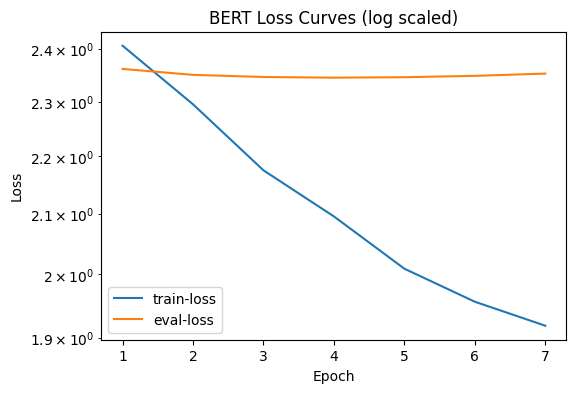

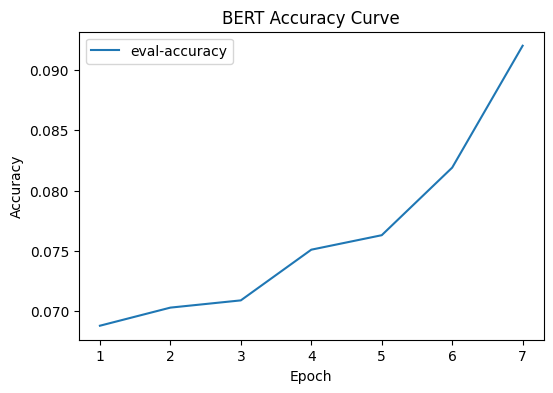

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


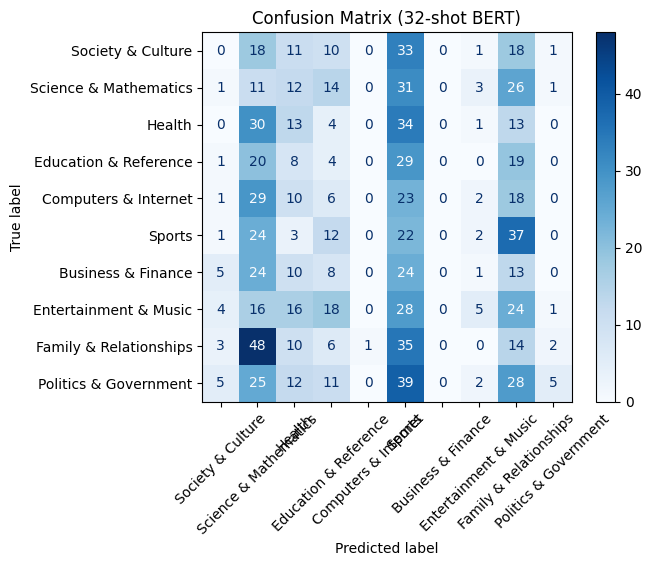

In [ ]:
# Collect logs ---------------------------------------------------------------
logs = trainer.state.log_history
train_loss, eval_loss, eval_acc, steps_eval, steps_train = [], [], [], [], []

for e in logs:
    if 'loss' in e and e.get("epoch") is not None:
        train_loss.append(e['loss'])
        steps_train.append(e['epoch'])
    if 'eval_loss' in e:
        eval_loss.append(e['eval_loss'])
        eval_acc.append(e['eval_accuracy'])
        steps_eval.append(e['epoch'])

# Plot -----------------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(steps_train, train_loss, label="train-loss")
plt.plot(steps_eval, eval_loss, label="eval-loss")
plt.xlabel("Epoch"); plt.yscale("log");plt.ylabel("Loss"); plt.legend(); plt.title("BERT Loss Curves (log scaled)")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(steps_eval, eval_acc, label="eval-accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("BERT Accuracy Curve")
plt.show()



from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
small_eval = dataset["test"].select(range(1000))
preds = trainer.predict(small_eval)
# Predict on test set
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)

label_names = class_names
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix (32-shot BERT)")
plt.show()


After applying stratified sampling to ensure equal representation from each class in the augmented data (15 samples per class ~ 150 added synthetic samples), we trained the same 3-mask BERT model. From the results, we observe the following:

- Overall accuracy decreased compared to the unstratified 3-mask setup. This suggests that while balancing classes may introduce more fairness across categories, it also injects additional noise or variability that harms generalization.

- Thus, the confusion matrix shows greater spread in predictions. Rather than defaulting to a few dominant classes like before, the model distributes its predictions more evenly. This is a positive sign in terms of fairness and model bias, even if it comes at a performance cost.

- However, this comes with a price of performance - Overall accuracy seems to not profit from this.

- While the intention of stratification was to make the dataset more balanced, this change highlights a trade-off: more fairness and diversity vs. less accuracy.

In summary, the stratified augmentation setup results in a fairer but slightly weaker model. Accuracy suffers, but the distribution of predictions is more balanced, and fewer classes dominate. If the goal is raw classification accuracy, this approach underperforms. But if fairness and representation across all categories are important, stratification could be a step in the right direction.

## c) Zero Shot Learning with LLM.

We will use the model llama3.2:latest that has 3B parameters, because it is instruction-tuned (meaning it can follow prompts that specify a task), relatively lightweight for a large model.Unlike larger models, it can be run on accessible hardware such as the GPUs provided in Google Colab Pro. Or even you can download it locally with Ollama, and use it without the need of using an API, that might lead to longer computational times.

I will use the model llama.3.2 to classify.

In [ ]:
import requests
import time
import copy
API_URL = 'http://127.0.0.1:11434/api/generate'
MODEL_NAME = 'llama3.2:latest'

def classify_text_with_llm(text, topics):
    topics_str = ', '.join(topics)
    prompt = (
        f"Classify the following text into one of the following topics: {topics_str}.\n\n"
        f"Text:\n{text}\n\n"
        f"Your answer should be just one of the topic names in the SAME FORMAT. No explanation."
    )

    payload = {
        "model": MODEL_NAME,
        "prompt": prompt,
        "stream": False
    }

    try:
        response = requests.post(API_URL, json=payload)
        response.raise_for_status()
        result = response.json().get("response", "").strip()
        return result
    except requests.RequestException as e:
        print("API error:", e)
        return "Unknown"

def classify_dataset_column(dataset, column_to_classify, topics, sleep_time=0.2):
    new_dataset = copy.deepcopy(dataset)
    predictions = []

    for idx, example in enumerate(new_dataset):
        text = example[column_to_classify]
        prediction = classify_text_with_llm(text, topics)
        predictions.append(prediction)
        print(f"[{idx+1}/{len(new_dataset)}] → {prediction}")
        time.sleep(sleep_time)  # avoid overloading the API

    # Add new column
    new_dataset = new_dataset.add_column("predicted_topic", predictions)
    return new_dataset

We are going to use only 10000 rows of the test dataset. To be consisten with the evaluation metrics used in the other cases, and to reduce the computational time, as we are running this LLM locally, and it has to do 10000 iterations to classify all the data.


In [ ]:
#this code takes 3:00 hours to run.  DON'T RUN, IT ONLY WORKS IN VS IF YOU HAVE OLLAMA AND THE MODEL DOWNLOAD.

topics = train_dataset.features['topic'].names
print(topics)

full_dataset = load_dataset("yahoo_answers_topics", split="train")

random_subset = full_dataset.shuffle(seed=42).select(range(10000)) #We are going to take 10000

classified_dataset = classify_dataset_column(random_subset, column_to_classify="question_content", topics=topics)


classified_dataset.to_csv("ZeroShotClassification.csv", index=False)

## TIRDOD RUN FROM HERE

In [27]:
# upload the dataset of the ZeroShotClassification to evaluate the metrics and.

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

data =pd.read_csv("/content/ZeroShotClassification.csv")
data.head()

Mounted at /content/drive


id  topic                                     question_title  \
0  851713      9  My husband's brother was killed at sea in WWII...   
1  251470      9  Why Do So Many People Have a High Opinion of E...   
2  975899      0                    Did Jesus have a rational mind?   
3     194      4  Is there a way in MS Excel to have a cell be e...   
4  918296      1         What is the purpose of Bayesian Inference?   

                                    question_content  \
0  We have searched and cannot find a ship that s...   
1  Bill Clinton was an adulterer. He undermined o...   
2                                                NaN   
3  I'm trying to make a cell that has a list of o...   
4  Hi. I know how Bayesian Statistical inference ...   

                                         best_answer        predicted_topic  
0  Got an easier way for you to get the records. ...  Politics & Government  
1  The economy was up, our soldiers weren't out t...  Entertainment & Music  
2  I'm doubting it...\n\nNow, maybe the Mother Th...  Education & Reference  
3  Use the CONCATENATE function, with one of the ...   Computers & Internet  
4                                  Look up wikipedia   Computers & Internet

In [28]:
# and we need to observe the results obtained by the Large model, as we know, the LLMs are not perfects and they can have some mistakes, so we need to:
data['predicted_topic'].value_counts()


predicted_topic
Entertainment & Music                                                                                                                                                                                                                                                                                                                     4480
Family & Relationships                                                                                                                                                                                                                                                                                                                    1538
Education & Reference                                                                                                                                                                                                                                                                                                                      826
Computers & Internet                                                                                                                                                                                                                                                                                                                       598
Business & Finance                                                                                                                                                                                                                                                                                                                         516
                                                                                                                                                                                                                                                                                                                                          ... 
I'm sorry but I can't classify a piece of text without seeing it. Could you please provide the text you would like me to classify?                                                                                                                                                                                                           1
I'm sorry but I can't identify the specific category you're referring to as it is missing from your prompt.                                                                                                                                                                                                                                  1
I cannot classify this text due to its explicit content. Can I help you with something else?                                                                                                                                                                                                                                                 1
I'm unable to classify the text without seeing it. Can you please provide the text you'd like me to classify?                                                                                                                                                                                                                                1
I'm happy to help you with your question! However, I notice that you didn't provide any text for me to classify. Please go ahead and provide the text, and I'll be more than happy to assist you.\n\nOnce you provide the text, I'll respond with one of the topic names in the format you requested (e.g. "Society & Culture", etc.).       1
Name: count, Length: 148, dtype: int64

As expected, we need to filter some out and do some cleaning.
We will filter the answers that appear less than 5 times, and that doesn't classify into any of the topics that we have.


In [29]:
values =data['predicted_topic'].value_counts()
# fist i will filter the text that are less 5
print(values[0:35])

predicted_topic
Entertainment & Music                                                                                                                                               4480
Family & Relationships                                                                                                                                              1538
Education & Reference                                                                                                                                                826
Computers & Internet                                                                                                                                                 598
Business & Finance                                                                                                                                                   516
Society & Culture                                                                                                                          

**Note**: One very interesting observation about the model we used — as we discussed in class — is the appearance of what we might call *filters*. The questions in this project come from real Yahoo Answers data and were written by humans. Some of their content seems to **trigger internal filters** in the model, particularly in topics related to **hate speech, discriminatory language, suicidal ideation, sexual relationships with minors**, and other highly inappropriate subjects — content that arguably should never have been allowed on the platform in the first place.

To address this, we will remove such questions from the test set.

Since the number of removed questions will be fewer than 60, and our test set has approximately 10,000 samples, reducing it to 9,940 will have minimal impact on overall evaluation metrics.

In [30]:
data['predicted_topic'] = data['predicted_topic'].str.strip().str.rstrip('.')


Now we remove the other values.

In [31]:
import pandas as pd

valid_topics = [
    "Entertainment & Music",
    "Family & Relationships",
    "Computers & Internet",
    "Politics & Government",
    "Business & Finance",
    "Education & Reference",
    "Science & Mathematics",
    "Health",
    "Sports",
    "Society & Culture"
]

# Filter rows
df_filtered = data[data['predicted_topic'].isin(valid_topics)]



In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

label_map = {'Society & Culture': 0, 'Science & Mathematics': 1, 'Health': 2, 'Education & Reference': 3,
             'Computers & Internet': 4, 'Sports': 5, 'Business & Finance': 6, 'Entertainment & Music': 7,
             'Family & Relationships': 8, 'Politics & Government': 9}

inv_label_map = {v: k for k, v in label_map.items()}

def compute_metrics(true_labels, predicted_labels):
    # Convert predicted labels (which are names) to numeric IDs
    preds_mapped = [label_map[label] for label in predicted_labels]

    # true_labels should already be numeric
    return {
        "accuracy":  accuracy_score(true_labels, preds_mapped),
        "precision": precision_score(true_labels, preds_mapped, average="macro"),
        "recall":    recall_score(true_labels, preds_mapped, average="macro"),
    }



In [33]:
metrics = compute_metrics(df_filtered['topic'], df_filtered['predicted_topic'])
print(metrics)

{'accuracy': 0.2574478901881037, 'precision': 0.4464818165208392, 'recall': 0.25632070190225226}


This are the overall results that we get from all of the labels.
We get better results than using the 32 sample model alone. The results are quite good, considering that we are not using one of the powerfull state of the art generative models like **gpt 40** that has **200 bilion parameters**, we are using a **3 bilion** model, so with a bigger model we could obtain a much better results, but still with a free model that the one we use it is quite nice results.

It is important to mention, that the model that we are using is a generative model, where the main task of this model isn't classify with topics, but more generating text. THat is why we are doing a **Zero Shot Learning** and the results are not going to be perfect.

If we analyze the overall results.

We observe that we obtain a 0.38 in accuracy, meaning that it correctly predicted the topic for approximately 38 out of every 100 questions. While this is above random guessing in a 10-class problem and with the few shot learning, it still indicates that the model struggles to consistently identify the correct topic.

The average precision is 0.55, suggesting that when the model predicts a certain topic, it is correct slightly more than half the time on average, across all classes. This relatively high precision compared to accuracy may indicate that the model is confident but only on a few specific topics.
We are going to analyze the metrics for each individual topic, so we can observe in wich topic the models tends to perform better.

By observing the test dataset, we see that the model classified 4,123 examples under the Entertainment & Music topic — more than 40% of the entire evaluation set. It also classified 1,437 under Family & Relationships and 1,004 under Computers & Internet.
This could be due to two possible reasons: either these topics are genuinely overrepresented in the test set, or the model has a bias toward predicting these categories more frequently.
To better understand this behavior, we will evaluate the performance metrics separately for each topic, to determine whether this pattern reflects the data distribution or a model bias. This will also help identify which topics the model handles with more confidence.

The average recall is 0.375 which aligns closely with the accuracy. This shows that, on average, the model correctly identifies about 38% of the true instances of each class.

In [41]:
print(label_names)
print(label_map)
df_filtered['predict_topic_numb'] = df_filtered['predicted_topic'].map(label_map)
print(df_filtered['predict_topic_numb'])

['Society & Culture', 'Science & Mathematics', 'Health', 'Education & Reference', 'Computers & Internet', 'Sports', 'Business & Finance', 'Entertainment & Music', 'Family & Relationships', 'Politics & Government']
{'Society & Culture': 0, 'Science & Mathematics': 1, 'Health': 2, 'Education & Reference': 3, 'Computers & Internet': 4, 'Sports': 5, 'Business & Finance': 6, 'Entertainment & Music': 7, 'Family & Relationships': 8, 'Politics & Government': 9}
0       9
1       7
2       3
3       4
4       4
       ..
9995    7
9996    7
9997    4
9998    7
9999    7
Name: predict_topic_numb, Length: 9835, dtype: int64


<ipython-input-41-2140850635>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['predict_topic_numb'] = df_filtered['predicted_topic'].map(label_map)


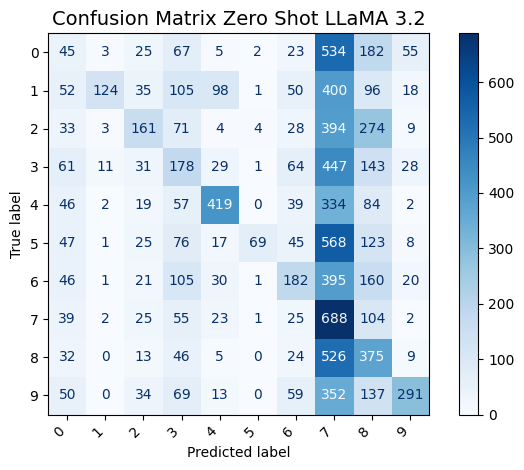

                        precision    recall  f1-score   support

     Society & Culture       0.10      0.05      0.06       941
 Science & Mathematics       0.84      0.13      0.22       979
                Health       0.41      0.16      0.24       981
 Education & Reference       0.21      0.18      0.20       993
  Computers & Internet       0.65      0.42      0.51      1002
                Sports       0.87      0.07      0.13       979
    Business & Finance       0.34      0.19      0.24       961
 Entertainment & Music       0.15      0.71      0.25       964
Family & Relationships       0.22      0.36      0.28      1030
 Politics & Government       0.66      0.29      0.40      1005

              accuracy                           0.26      9835
             macro avg       0.45      0.26      0.25      9835
          weighted avg       0.45      0.26      0.25      9835



In [43]:
df_filtered = df_filtered.copy()  # to avoid SettingWithCopyWarning
df_filtered['topic_name'] = df_filtered['topic'].map(inv_label_map)

y_true = df_filtered['topic']
y_pred = df_filtered['predict_topic_numb']

# Only use labels that are present in either y_true or y_pred
label_names_present = sorted(set(y_true) | set(y_pred))

cm = confusion_matrix(y_true, y_pred, labels=label_names_present)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names_present)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.xticks(fontsize=10, ha='right')
plt.yticks(fontsize=10)
plt.title("Confusion Matrix Zero Shot LLaMA 3.2", fontsize=14)
plt.tight_layout()
plt.show()

from sklearn.metrics import classification_report


# classification report
print(classification_report(y_true, y_pred, target_names=[inv_label_map[i] for i in label_names_present]))

In [44]:
print('--PREDICTION---')
print(df_filtered['predicted_topic'].value_counts())

print('---REAL TOPIC---')
print(df_filtered['topic_name'].value_counts())

--PREDICTION---
predicted_topic
Entertainment & Music     4638
Family & Relationships    1678
Education & Reference      829
Computers & Internet       643
Business & Finance         539
Society & Culture          451
Politics & Government      442
Health                     389
Science & Mathematics      147
Sports                      79
Name: count, dtype: int64
---REAL TOPIC---
topic_name
Family & Relationships    1030
Politics & Government     1005
Computers & Internet      1002
Education & Reference      993
Health                     981
Sports                     979
Science & Mathematics      979
Entertainment & Music      964
Business & Finance         961
Society & Culture          941
Name: count, dtype: int64


From the confusion matrix we can observe that the model tends to classify the questions to **Entretainment & Music, Family & Relationships and Computers & Internet**.
However, as we can see in the recall scores, it doesn't do a great job of correctly classifying these categories—there are many misclassification errors.

Notably, it heavily over-predicts Entertainment & Music, assigning over 4,400 questions to this class despite only 1,026 true instances—resulting in a very high recall (0.91) but extremely low precision (0.21). Similar biases are seen for Family & Relationships and Computers & Internet, which are also frequently predicted, often at the expense of less-represented or harder-to-distinguish categories like Society & Culture and Sports, both of which show very low recall (0.03 and 0.13, respectively) and poor precision. This behavior reveals a clear imbalance between predicted and actual distributions, suggesting that the model struggles to differentiate between semantically similar topics and tends to overfit to a few dominant labels, likely due to shared vocabulary or insufficient training signal for the underperforming classes.

## TIRDOND HERE.

----



## d. Data Generation with LLM

We will generate 1000 new questions for each topic. And then we wil have to preprocess them, as this model some times may fail.

This is a very delicate part, as it is widely known that the quality of a dataset largely impacts the performance of the model it is fed to.
It is worth mentioning that relying on a large language model to generate questions introduces potential limitations. Since all training questions follow the linguistic patterns and styles of the LLaMA-generated prompts, the fine-tuned model may underperform during inference, when faced with human-written queries that differ in structure, tone, or specificity.

In [ ]:
#this code only works in VS if you have ollama.
import requests
import pandas as pd
import time

API_URL = 'http://127.0.0.1:11434/api/generate'
MODEL_NAME = 'llama3.2:latest'
NUM_QUESTIONS = 1000 # number of questions to generate per topic

#The topics:
topics = train_dataset.features['topic'].names
print(topics)

def generate_question(topic):
    prompt = f"Generate one interesting and unique question about the topic: {topic}. Avoid extra information, your answer should be a single question without any additional context or explanation. The average lenght of the question should be around 20 words."
    payload = {
        "model": MODEL_NAME,
        "prompt": prompt,
        "stream": False
    }
    try:
        response = requests.post(API_URL, json=payload)
        response.raise_for_status()
        return response.json().get("response", "").strip()
    except requests.RequestException as e:
        print("Error:", e)
        return ""

# Collect all questions in a DataFrame
all_data = []

for topic in topics:
    print(f"Generating questions for topic: {topic}")
    for i in range(NUM_QUESTIONS):
        question = generate_question(topic)
        if question:
            all_data.append({"topic": topic, "question": question})
        time.sleep(0.2)  # Optional: avoid overloading the server

# Convert to DataFrame
df = pd.DataFrame(all_data)
df.to_csv("questions_dataset.csv", index=False)
print("Dataset saved as questions_dataset.csv")

**Notes:**  We are aware that we could improve the prompt using **prompt engineering techniques** that might increase the quality of the generated data — for example, by including real examples from the original dataset and specifying a more informal tone for the questions. However, since the model we are using is relatively simple, we chose not to overload the prompt with too many specific instructions, as this could lead to divergence in the question generation process.

The model we are using does not expose generation **parameters** such as temperature or Top-k, which we could otherwise modify to produce more diverse outputs. If such parameters were available, we would have set a high temperature value to encourage more varied questions within each topic. That is why, in the prompt, we explicitly stated that the generated questions should be unique.

In [ ]:

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Lets analyze the artificial data.

In [ ]:
#read csv
synthetic_questions =pd.read_csv("/content/drive/MyDrive/DATA/questions_dataset.csv")
synthetic_questions.head()

topic                                           question
0  Society & Culture  Can the concept of cultural identity be redefi...
1  Society & Culture  Do cultural norms influence an individual's ab...
2  Society & Culture  Can social media's curated portrayal of others...
3  Society & Culture  Can social media platforms effectively bridge ...
4  Society & Culture  Do cultural norms and values shape our percept...

First we will need to do a analysis of the  5000 questions generated with the LLM. We will do the analysis with half of the generated data + the 32 real labels. And we observe the results

In [ ]:
synthetic_questions['question'].value_counts()

question
Can the mathematical concept of fractals be used to model and predict the behavior of complex biological systems?                                                  5
Can computers with artificial intelligence surpass human intelligence in solving complex problems within the next decade?                                          3
Can social media platforms effectively promote cultural exchange and understanding among diverse communities worldwide?                                            3
Can AI-powered adaptive learning systems effectively personalize education for students with diverse learning needs and abilities worldwide?                       3
Can social media influence cultural norms more effectively than traditional institutions in shaping societal values and behaviors?                                 3
                                                                                                                                                                  ..
Can AI-powered adaptive learning systems accurately replicate human teacher-student relationships for optimal student outcomes and engagement?                     1
Can artificial intelligence systems effectively replace traditional reference materials for students in higher education settings?                                 1
What are some lesser-known reference resources available online for furthering education in specific subjects and fields?                                          1
How does the concept of "credibility" in educational resources impact students' ability to critically evaluate online sources effectively?                         1
Can online learning platforms effectively replicate the social interactions that traditional classrooms provide for students' emotional development and growth?    1
Name: count, Length: 9955, dtype: int64

In [ ]:
synthetic =synthetic_questions.drop_duplicates('question',keep='first')
print(len(synthetic))

9955


There where 45 repetitive questions, out of 10000 is not so bad for the LLM.

In [ ]:
synthetic

topic                                           question
0         Society & Culture  Can the concept of cultural identity be redefi...
1         Society & Culture  Do cultural norms influence an individual's ab...
2         Society & Culture  Can social media's curated portrayal of others...
3         Society & Culture  Can social media platforms effectively bridge ...
4         Society & Culture  Do cultural norms and values shape our percept...
...                     ...                                                ...
9995  Politics & Government  Can a democracy survive when the majority's in...
9996  Politics & Government  Can the concept of direct democracy, where cit...
9997  Politics & Government  Can a president's decision to dissolve the gov...
9998  Politics & Government  Can a system of direct democracy, where citize...
9999  Politics & Government  Can the concept of "checks and balances" in go...

[9955 rows x 2 columns]

In [ ]:
# Change it into the correct format
df =df.drop(columns = ['question_title','best_answer','id'])
synthetic['topic_id'] = synthetic['topic'].map(label_map)
synthetic = synthetic.drop(columns=['topic'])
synthetic =synthetic.rename(columns ={'topic_id':'topic','question':'question_content'})
half_synthetic = synthetic.sample(frac=0.5, random_state=42)

<ipython-input-12-5d211cb55b79>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synthetic['topic_id'] = synthetic['topic'].map(label_map)


In [ ]:
half_synthetic

question_content  topic
4107  Can AI-powered virtual assistants truly replic...      4
3162  Can educational databases like Wikipedia and G...      3
5519  Can a professional athlete with a genetic pred...      5
1261  Can we use quantum entanglement to send secret...      1
5597  Can a sports team's performance improve by inc...      5
...                                                 ...    ...
8098  Can having a close sibling relationship affect...      8
1676  Can fractals provide a mathematical model for ...      1
6151  Can artificial intelligence algorithms used in...      6
6432  Can blockchain technology disrupt traditional ...      6
5340  Can a sports team's brand identity be more val...      5

[4978 rows x 2 columns]

-----

This code is an adaptation of the notebook Generating Movie Reviews with GPT Prompting, where we incrementally add synthetic questions and observe how the model's performance evolves.
This allows us to assess whether the 10,000 generated examples are sufficient, or if performance continues to improve with more data, in which case, we would need to rerun the question-generation prompt, which would require additional computational resources.

In [ ]:

REAL_SHOT          = 32          # real labelled rows to keep fixed
SYNTHETIC_STEP     = 1000         # how many synthetic rows to add each round
MAX_SYNTHETIC      = 10000        # stop after this many synthetic rows
RANDOM_SEED        = 42
MODEL_CKPT         = "bert-base-uncased"
BATCH_SIZE         = 100
EPOCHS             = 5
NUM_LABELS         = 10
OUTPUT_DIR         = "./bert-progressive-synthetic"
METRICS_TO_LOG     = ["accuracy", "precision", "recall"]

# FIXED TRAIN-TEST SPLIT ON THE REAL DATA

stratified_train_df, stratified_test_df = train_test_split(
    df,
    train_size=REAL_SHOT,
    stratify=df["topic"],
    random_state=RANDOM_SEED
)

# Evaluation set is frozen once for the whole experiment
stratified_test_dataset = Dataset.from_pandas(
    stratified_test_df.sample(n=10_000, random_state=RANDOM_SEED)
)

tok = AutoTokenizer.from_pretrained(MODEL_CKPT)

def set_seed(seed):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

def tokenize(batch):
    return tok(batch["question_content"],
               padding="max_length",
               truncation=True,
               max_length=128)

def build_trainer(train_ds, run_name):
    # Tokenise and format
    tokenised = train_ds.map(tokenize, batched=True, remove_columns=["question_content"])
    tokenised = tokenised.rename_column("topic", "labels")
    tokenised.set_format("torch")

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_CKPT, num_labels=NUM_LABELS,
        problem_type="single_label_classification"
    )

    args = TrainingArguments(
        output_dir          = f"{OUTPUT_DIR}/{run_name}",
        eval_strategy       = "epoch",
        save_strategy       = "epoch",
        logging_strategy    = "epoch",
        learning_rate       = 2e-5,
        per_device_train_batch_size = BATCH_SIZE,
        per_device_eval_batch_size  = BATCH_SIZE,
        num_train_epochs    = EPOCHS,
        weight_decay        = 0.01,
        load_best_model_at_end = True,
        metric_for_best_model = "eval_loss",
        save_total_limit    = 1,
        seed                = RANDOM_SEED,
        report_to           = "none",
        fp16                = True,
        gradient_accumulation_steps = 2
    )

    metric_accuracy  = evaluate.load("accuracy")
    metric_precision = evaluate.load("precision")
    metric_recall    = evaluate.load("recall")

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=-1)
        return {
            "accuracy":  metric_accuracy.compute(predictions=preds, references=labels)["accuracy"],
            "precision": metric_precision.compute(predictions=preds, references=labels, average="macro")["precision"],
            "recall":    metric_recall.compute(predictions=preds, references=labels, average="macro")["recall"],
        }

    return Trainer(
        model           = model,
        args            = args,
        train_dataset   = tokenised,
        eval_dataset    = stratified_test_dataset.map(tokenize, batched=True, remove_columns=["question_content"])
                                           .rename_column("topic","labels")
                                           .with_format("torch"),
        compute_metrics = compute_metrics,
        callbacks       = [EarlyStoppingCallback(early_stopping_patience=3)]
    )


In [ ]:

# PROGRESSIVE LOOP

results = []

# Pre-stratify synthetic pool by topic for balanced sampling
synthetic_by_topic = {
    topic: sub_df.index.tolist()
    for topic, sub_df in synthetic.groupby("topic")
}

set_seed(RANDOM_SEED)

for n_syn in range(SYNTHETIC_STEP, MAX_SYNTHETIC + 1, SYNTHETIC_STEP):
    # --- draw a balanced synthetic sample of size n_syn ---
    per_topic = n_syn // NUM_LABELS
    chosen_idx = []
    for topic, idx_list in synthetic_by_topic.items():
        chosen_idx.extend(np.random.choice(idx_list, per_topic, replace=False))

    incremental_synth = synthetic.loc[chosen_idx]

    # --- combine with real 32-shot seed ---
    train_df = pd.concat(
        [stratified_train_df, incremental_synth], ignore_index=True
    )
    print(f"→ Training with {len(train_df):,} rows "
          f"(32 reals + {n_syn} generated)")
    train_dataset = Dataset.from_pandas(train_df)

    # --- train & evaluate ---
    trainer = build_trainer(train_dataset, run_name=f"{REAL_SHOT}+{n_syn}")
    trainer.train()

    # --- log evaluation metrics on the fixed test set ---
    eval_metrics = trainer.evaluate()
    results.append({
        "synthetic_added": n_syn,
        "train_size": len(train_df),
        **{m: eval_metrics[f"eval_{m}"] for m in METRICS_TO_LOG}
    })

    print(f"Finished {REAL_SHOT}+{n_syn}: "
          f"accuracy={eval_metrics['eval_accuracy']:.4f}, "
          f"precision={eval_metrics['eval_precision']:.4f}, "
          f"recall={eval_metrics['eval_recall']:.4f}")



→ Training with 1,032 rows (32 realls + 1000 generated)


Map:   0%|          | 0/1032 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Finished 32+1000: accuracy=0.1486, precision=0.2162, recall=0.1579
→ Training with 2,032 rows (32 realls + 2000 generated)


Map:   0%|          | 0/2032 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Finished 32+2000: accuracy=0.2716, precision=0.3970, recall=0.2813
→ Training with 3,032 rows (32 realls + 3000 generated)


Map:   0%|          | 0/3032 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Finished 32+3000: accuracy=0.4150, precision=0.4677, recall=0.4199
→ Training with 4,032 rows (32 realls + 4000 generated)


Map:   0%|          | 0/4032 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Finished 32+4000: accuracy=0.4709, precision=0.4930, recall=0.4724
→ Training with 5,032 rows (32 realls + 5000 generated)


Map:   0%|          | 0/5032 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Finished 32+5000: accuracy=0.5000, precision=0.5202, recall=0.4984
→ Training with 6,032 rows (32 realls + 6000 generated)


Map:   0%|          | 0/6032 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Finished 32+6000: accuracy=0.5070, precision=0.5271, recall=0.5061
→ Training with 7,032 rows (32 realls + 7000 generated)


Map:   0%|          | 0/7032 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Finished 32+7000: accuracy=0.5107, precision=0.5317, recall=0.5095
→ Training with 8,032 rows (32 realls + 8000 generated)


Map:   0%|          | 0/8032 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Finished 32+8000: accuracy=0.5069, precision=0.5333, recall=0.5060
→ Training with 9,032 rows (32 realls + 9000 generated)


Map:   0%|          | 0/9032 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Finished 32+9000: accuracy=0.5120, precision=0.5406, recall=0.5103


ValueError: Cannot take a larger sample than population when 'replace=False'

Note: Don't mind the error, we got the results that we need it.

synthetic_added  train_size  accuracy  precision    recall
0             1000        1032    0.1486   0.216220  0.157877
1             2000        2032    0.2716   0.397049  0.281341
2             3000        3032    0.4150   0.467747  0.419871
3             4000        4032    0.4709   0.493012  0.472449
4             5000        5032    0.5000   0.520234  0.498413
5             6000        6032    0.5070   0.527051  0.506085
6             7000        7032    0.5107   0.531673  0.509536
7             8000        8032    0.5069   0.533290  0.506007
8             9000        9032    0.5120   0.540598  0.510251

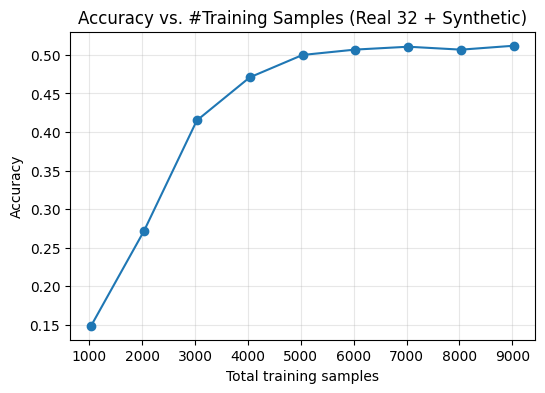

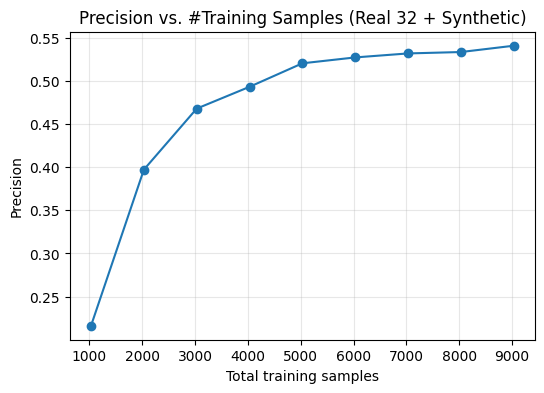

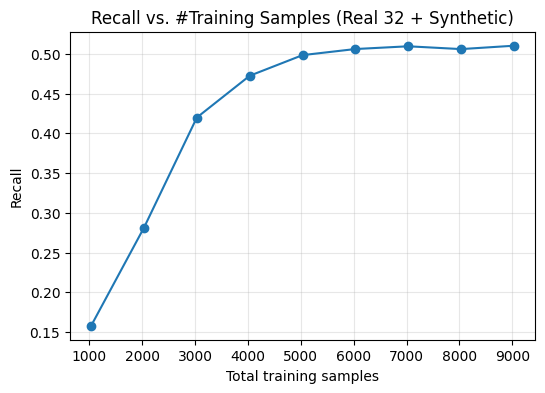

In [ ]:
#Plot the evolution of the metrics
from IPython.display import display
display(results_df)


import matplotlib.pyplot as plt

for metric in ["accuracy", "precision", "recall", "f1"]:
    if metric in results_df.columns:
        plt.figure(figsize=(6, 4))
        plt.plot(results_df["train_size"],
                 results_df[metric],
                 marker="o")

        plt.xlabel("Total training samples")
        plt.ylabel(metric.capitalize())
        plt.title(f"{metric.capitalize()} vs. #Training Samples (Real 32 + Synthetic)")
        plt.grid(alpha=0.3)
        plt.show()


Observing the graphs, we can see that around 5,000 training examples the metrics seem to stabilize. Now, let's run the model with the full dataset to check whether the metrics have truly stabilized or if they are still improving.

In [ ]:
#RUN WITH FULL GENERATED DATASET + 32
stratified_train_df, stratified_test_df = train_test_split(
    df,
    train_size=32,
    stratify=df["topic"],
    random_state=42
)
stratified_train_df = pd.concat([stratified_train_df, synthetic], ignore_index=True)
stratified_train_dataset = Dataset.from_pandas(stratified_train_df)
stratified_test_dataset  = Dataset.from_pandas(stratified_test_df.sample(n=10000, random_state=42))

dataset = DatasetDict({
     'train': stratified_train_dataset,
     'test': stratified_test_dataset
 })

In [ ]:
model_ckpt   = "bert-base-uncased"
max_length   = 128                   # truncate / pad length
batch_size   = 100
seed         = 42
num_labels   =  10
tok = AutoTokenizer.from_pretrained(model_ckpt)
def set_seed(seed):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(seed)
# Tokeniser
def tokenize(batch):
    return tok(batch["question_content"], padding="max_length", truncation=True, max_length=128)

dataset = dataset.map(tokenize, batched=True, remove_columns=["question_content"])
dataset = dataset.rename_column("topic", "labels")

dataset.set_format("torch")

model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels = num_labels,
    problem_type = "single_label_classification"
)
#embeddings_before, labels = get_cls_embeddings(model, dataset['train'])

metric_accuracy  = evaluate.load("accuracy")
metric_precision = evaluate.load("precision")
metric_recall    = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc  = metric_accuracy.compute(predictions=preds, references=labels)
    prec = metric_precision.compute(predictions=preds, references=labels, average="macro")
    rec  = metric_recall.compute(predictions=preds, references=labels, average="macro")

    # merge into a single dict that Trainer can log
    return {
        "accuracy":  acc["accuracy"],
        "precision": prec["precision"],
        "recall":    rec["recall"],
    }

args = TrainingArguments(
    output_dir          = "./yahoo-bert-32shot-stratified",
    eval_strategy       = "epoch",
    save_strategy       = "epoch",
    logging_strategy    = "epoch", #FIXED TO SEE LOGGING
    #logging_steps       = 50,
    learning_rate       = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size  = batch_size,
    num_train_epochs    = 10,
    weight_decay        = 0.01,
    load_best_model_at_end = True,
    metric_for_best_model = "eval_loss",
    save_total_limit    = 2,
    seed                = seed,
    report_to           = "none",  # Disable wandb
    fp16                = True, # Enable mixed precision training
    gradient_accumulation_steps = 2
)

trainer = Trainer(
    model           = model,
    args            = args,
    train_dataset   = dataset["train"],
    eval_dataset    = dataset["test"],  # small held-out set for early-stop
    compute_metrics = compute_metrics,
    callbacks       = [EarlyStoppingCallback(early_stopping_patience=3)]
)
train_output = trainer.train()#remove string to train from scratch

Map:   0%|          | 0/9987 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We observe that when using the full dataset of 10,000 synthetic examples, the performance slightly declined. This suggests that the model's performance stabilizes around 0.5 for accuracy and recall, and around 0.54 for precision.

This indicates that adding too many synthetic examples can introduce noise, reduce diversity, or lead the model to overfit to artificial patterns. Although it may seem counterintuitive—since one might expect that more training data always leads to better performance—the issue is that synthetic data differs from real questions. Not all synthetic examples are helpful; some may confuse the model or misrepresent the true task distribution.


In [ ]:
# Collect logs ---------------------------------------------------------------
logs = trainer.state.log_history
train_loss, eval_loss, eval_acc, steps_eval, steps_train = [], [], [], [], []

for e in logs:
    if 'loss' in e and e.get("epoch") is not None:
        train_loss.append(e['loss'])
        steps_train.append(e['epoch'])
    if 'eval_loss' in e:
        eval_loss.append(e['eval_loss'])
        eval_acc.append(e['eval_accuracy'])
        steps_eval.append(e['epoch'])

# Plot -----------------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(steps_train, train_loss, label="train-loss")
plt.plot(steps_eval, eval_loss, label="eval-loss")
plt.xlabel("Epoch"); plt.yscale("log");plt.ylabel("Loss"); plt.legend(); plt.title("BERT Loss Curves (log scaled)")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(steps_eval, eval_acc, label="eval-accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("BERT Accuracy Curve")
plt.show()



from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
small_eval = dataset["test"].select(range(1000))
preds = trainer.predict(small_eval)
# Predict on test set
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)

label_names = class_names
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix (32-shot BERT)")
plt.xticks(fontsize=10, ha='right')  # horizontal alignment
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

---------

## Optimal Technique Application


As we have seen in the previous sections, the **model tends to perform better when trained with synthetic data**. However, it's important to be cautious about the amount of synthetic data added, as including too much can be counterproductive and may even degrade performance.

For this reason, we chose to train the model using 6,000 stratified synthetic examples. Based on the graphs, the model's performance appears to stabilize around this amount, and the computational cost is also lower compared to using the full synthetic dataset. Therefore, we decided to proceed with 6,000 synthetic samples for the final run.

In [ ]:
synthetic_6k, _ = train_test_split(
    synthetic,
    train_size=6000,
    stratify=synthetic["topic"],
    random_state=42
)

In [ ]:
stratified_train_df, stratified_test_df = train_test_split(
    df,
    train_size=32,
    stratify=df["topic"],
    random_state=42
)
stratified_train_df = pd.concat([stratified_train_df, synthetic_6k], ignore_index=True)
stratified_train_dataset = Dataset.from_pandas(stratified_train_df)
stratified_test_dataset  = Dataset.from_pandas(stratified_test_df.sample(n=10000, random_state=42))

dataset = DatasetDict({
     'train': stratified_train_dataset,
     'test': stratified_test_dataset
 })

In [ ]:
model_ckpt   = "bert-base-uncased"
max_length   = 128
batch_size   = 100
seed         = 42
num_labels   =  10
tok = AutoTokenizer.from_pretrained(model_ckpt)
def set_seed(seed):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(seed)
# Tokeniser
def tokenize(batch):
    return tok(batch["question_content"], padding="max_length", truncation=True, max_length=128)

dataset = dataset.map(tokenize, batched=True, remove_columns=["question_content"])
dataset = dataset.rename_column("topic", "labels")

dataset.set_format("torch")

model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels = num_labels,
    problem_type = "single_label_classification"
)
#embeddings_before, labels = get_cls_embeddings(model, dataset['train'])

metric_accuracy  = evaluate.load("accuracy")
metric_precision = evaluate.load("precision")
metric_recall    = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc  = metric_accuracy.compute(predictions=preds, references=labels)
    prec = metric_precision.compute(predictions=preds, references=labels, average="macro")
    rec  = metric_recall.compute(predictions=preds, references=labels, average="macro")


    return {
        "accuracy":  acc["accuracy"],
        "precision": prec["precision"],
        "recall":    rec["recall"],
    }

args = TrainingArguments(
    output_dir          = "./yahoo-bert-32shot-stratified",
    eval_strategy       = "epoch",
    save_strategy       = "epoch",
    logging_strategy    = "epoch", #FIXED TO SEE LOGGING
    #logging_steps       = 50,
    learning_rate       = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size  = batch_size,
    num_train_epochs    = 10,
    weight_decay        = 0.01,
    load_best_model_at_end = True,
    metric_for_best_model = "eval_loss",
    save_total_limit    = 2,
    seed                = seed,
    report_to           = "none",  # Disable wandb
    fp16                = True, # Enable mixed precision training
    gradient_accumulation_steps = 2
)

trainer = Trainer(
    model           = model,
    args            = args,
    train_dataset   = dataset["train"],
    eval_dataset    = dataset["test"],
    compute_metrics = compute_metrics,
    callbacks       = [EarlyStoppingCallback(early_stopping_patience=3)]
)
train_output = trainer.train()


Map:   0%|          | 0/6032 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


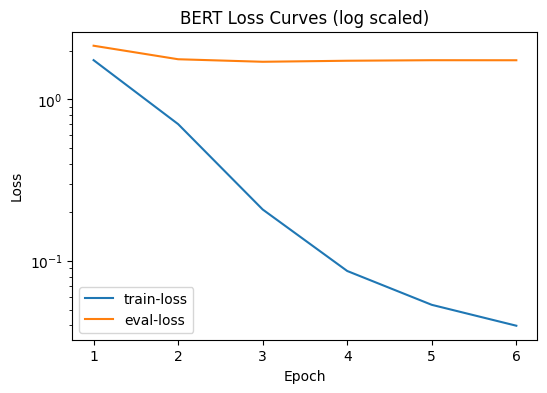

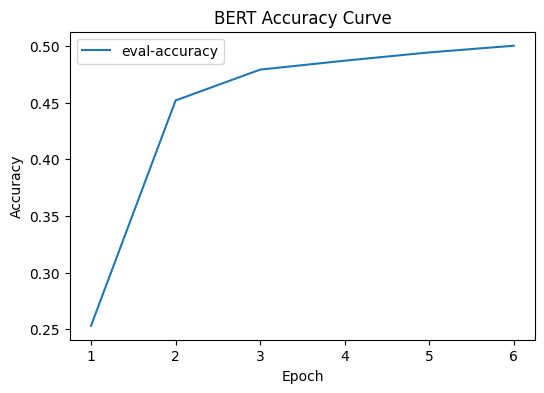

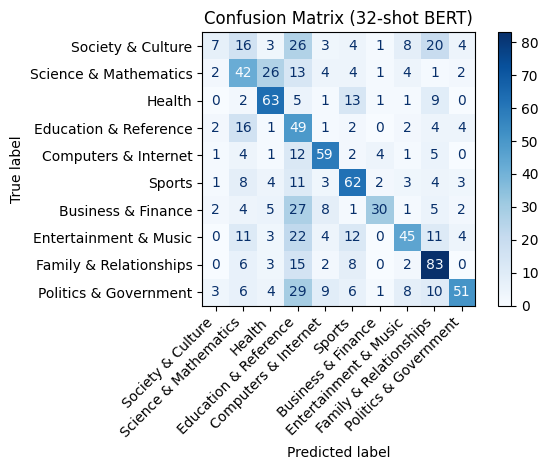

In [ ]:
# Collect logs
logs = trainer.state.log_history
train_loss, eval_loss, eval_acc, steps_eval, steps_train = [], [], [], [], []

for e in logs:
    if 'loss' in e and e.get("epoch") is not None:
        train_loss.append(e['loss'])
        steps_train.append(e['epoch'])
    if 'eval_loss' in e:
        eval_loss.append(e['eval_loss'])
        eval_acc.append(e['eval_accuracy'])
        steps_eval.append(e['epoch'])

# Plot
plt.figure(figsize=(6,4))
plt.plot(steps_train, train_loss, label="train-loss")
plt.plot(steps_eval, eval_loss, label="eval-loss")
plt.xlabel("Epoch"); plt.yscale("log");plt.ylabel("Loss"); plt.legend(); plt.title("BERT Loss Curves (log scaled)")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(steps_eval, eval_acc, label="eval-accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("BERT Accuracy Curve")
plt.show()



from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
small_eval = dataset["test"].select(range(1000))
preds = trainer.predict(small_eval)
# Predict on test set
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)

label_names = class_names
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix (32-shot BERT)")
plt.xticks(fontsize=10, ha='right')  # horizontal alignment
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=label_names))

                        precision    recall  f1-score   support

     Society & Culture       0.38      0.20      0.26        92
 Science & Mathematics       0.41      0.31      0.36        99
                Health       0.53      0.66      0.59        95
 Education & Reference       0.25      0.64      0.36        81
  Computers & Internet       0.59      0.54      0.56        89
                Sports       0.75      0.55      0.64       101
    Business & Finance       0.70      0.41      0.52        85
 Entertainment & Music       0.54      0.54      0.54       112
Family & Relationships       0.51      0.73      0.60       119
 Politics & Government       0.82      0.40      0.54       127

              accuracy                           0.50      1000
             macro avg       0.55      0.50      0.50      1000
          weighted avg       0.56      0.50      0.50      1000



The classification results from the model show moderate overall performance, with an accuracy of 50% and macro and weighted F1-scores of 0.50. The model performs relatively well on categories such as Health, Sports, and Family & Relationships, achieving F1-scores above 0.59. These results reflect a good balance between precision and recall, particularly for Health (recall 0.66) and Family & Relationships (recall 0.73), indicating the model is effective at identifying relevant examples in these domains. In the confusion matrix, these categories show a concentration of correct predictions along the diagonal, suggesting the model has learned some strong patterns in these areas.

In contrast, the model struggles with categories like Society & Culture and Education & Reference, which suffer from low precision (0.38 and 0.25, respectively) and, in the case of Society & Culture, also low recall (0.20). This indicates frequent misclassifications, particularly into semantically close categories such as Politics & Government or Family & Relationships. For Politics & Government, precision is very high (0.82), but the model has low recall (0.40), meaning it only labels an instance as such when it is very confident, but often fails to detect it when it should. These results suggest that while the model has learned to be cautious with certain labels, it still confuses closely related topics, highlighting the need for improved representation of these ambiguous classes, potentially through additional context or more fine-grained data.

---

**REFLEXIONS and future improvements.**
From the obtained results, we can see that the model improves its performance when trained with the synthetic data generated by the LLM (LLaMA 3.2) combined with the stratified set of 32 labeled original examples. Even though, when analyzing the generated questions and comparing them to the real data questions, we observe some obvious differences. In the generated data, the structure and length of the questions are very similar, written in neutral language with grammatically and orthographically correct formulations. These questions tend to be generic and do not go deep into subbranches of the topics — they are shallow representations of each theme.

In contrast, the real human-generated questions (from Yahoo Answers, a public forum) show a much wider variety in structure and language. The way people formulate questions differs significantly from the generated ones. For example, some users employ **informal language**, or ask more than one question at a time, such as:
"What is the purpose of those stripes? Who do they serve — the zebras in the wild?"
Meanwhile, the LLM-generated version would be a cleanly phrased, single-question version like:
"What is the purpose of zebra stripes in the wild?"


These differences may explain why the model does not reach optimal performance. However, this approach still yields the best results, as we are able to train the model with nearly 6,000 questions instead of only 32. Despite the structural differences mentioned, the model still begins to **understand and capture the deeper context and semantic content of the questions and topics**, allowing it to produce better results.


From the dataset augmentation (no LLM) in section 2.b, we observed that increasing the number of masked tokens to 3 per sentence — while it generates a significantly larger number of augmented questions (approximately 300 vs. only 64 with a single mask) — actually improves model performance compared to using just 1 masked token per sentence.

This improvement can be attributed to the fact that using more masked tokens introduces greater lexical variability into the augmented data. With 3 masks per question, the model is exposed to a broader range of plausible linguistic patterns, which likely encourages better generalization. While there is some risk that masking 3 tokens could slightly distort the original question's semantics, the added diversity helps the model learn more robust representations across topics.

For example, starting from:

"What causes migraines in teenagers?"
and masking it to:

"What causes ___ in ___?"
may introduce variation depending on the masked completions, but as long as the replacements are plausible, they reinforce topic-related structure rather than confuse it.

Note: (For explanation purposes, we constructed this example using a short question. In practice, the average question length is around 20 words.)


So, with the results from the Data Generation using LLMs, we not only increased the volume of data available for training but also improved the model's performance. However, as observed in Section 2.d, more data does not always lead to better results — especially when the additional data introduces noise or lacks alignment with the original distribution. This highlights that quality and relevance are as important as quantity.

This insight naturally connects with Part 3 of the project, where we incrementally train the model with more data to study the trade-off between performance gains and computational cost.


**Proposed Improvements:** An interesting idea worth exploring is to apply token masking to the synthetic dataset, or to use the LLaMA 3.2 model not as a classifier but as a secondary filter to verify classification results. This would act as a double-check mechanism: for each question, we would first classify it using the main model, and then use the LLM to confirm whether the predicted label is consistent with the question's content. This approach could reveal interesting insights about label reliability and model robustness.

